# CS 441 final project

In [8]:
import os
import numpy as np
from PIL import Image
import time
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

import torch.nn as nn
import torch.optim as optim
DRIVE_BASE = "/content/drive/My Drive/CS441/Final/garbage_dataset"
LOCAL_TRAIN = "/content/garbage_train"
LOCAL_TEST  = "/content/garbage_test"

FORCE_SYNC = False

from google.colab import drive
drive.mount("/content/drive")

!pip -q install pillow-heif
from PIL import Image
import pillow_heif
pillow_heif.register_heif_opener()

import os, subprocess

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp", ".heic", ".heif")

def count_images(root):
    if not os.path.exists(root):
        return 0
    c = 0
    for _, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(IMG_EXTS):
                c += 1
    return c

def rsync_dir(src, dst):
    cmd = ["rsync", "-a", "--delete", "--info=progress2", src.rstrip("/") + "/", dst.rstrip("/") + "/"]
    print("Running:", " ".join([f'"{x}"' if " " in x else x for x in cmd]))
    subprocess.run(cmd, check=True)

drive_train = os.path.join(DRIVE_BASE, "train")
drive_test  = os.path.join(DRIVE_BASE, "test")

if not os.path.exists(drive_train):
    raise FileNotFoundError(f"Not found: {drive_train}")
if not os.path.exists(drive_test):
    raise FileNotFoundError(f"Not found: {drive_test}")

drive_train_cnt = count_images(drive_train)
drive_test_cnt  = count_images(drive_test)

local_train_cnt = count_images(LOCAL_TRAIN)
local_test_cnt  = count_images(LOCAL_TEST)

print(f"Drive train images: {drive_train_cnt} | Local train images: {local_train_cnt}")
print(f"Drive test  images: {drive_test_cnt}  | Local test  images: {local_test_cnt}")

need_sync = FORCE_SYNC or (drive_train_cnt != local_train_cnt) or (drive_test_cnt != local_test_cnt)
print("Need sync:", need_sync)

if need_sync:
    rsync_dir(drive_train, LOCAL_TRAIN)
    rsync_dir(drive_test,  LOCAL_TEST)

train_root = LOCAL_TRAIN
test_root  = LOCAL_TEST

local_train_cnt2 = count_images(train_root)
local_test_cnt2  = count_images(test_root)

print("\n=== READY ===")
print("train_root =", train_root, "| images:", local_train_cnt2)
print("test_root  =", test_root,  "| images:", local_test_cnt2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive train images: 20371 | Local train images: 20371
Drive test  images: 251  | Local test  images: 251
Need sync: False

=== READY ===
train_root = /content/garbage_train | images: 20371
test_root  = /content/garbage_test | images: 251


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [10]:
class GarbageFineDataset(Dataset):
    def __init__(self, root_dir, transform=None,
                 fine_class_to_idx=None, big_class_to_idx=None,
                 strict=False,
                 extensions=('.jpg', '.jpeg', '.png', '.bmp', '.webp', '.heic', '.heif')):
        self.root_dir = root_dir
        self.transform = transform
        self.extensions = extensions
        self.strict = strict

        self.fine_class_to_idx = {} if fine_class_to_idx is None else dict(fine_class_to_idx)
        self.big_class_to_idx  = {} if big_class_to_idx  is None else dict(big_class_to_idx)

        self.samples = []  # (image_path, fine_idx, big_idx)

        big_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        for big_name in big_names:
            big_path = os.path.join(root_dir, big_name)

            if big_name in self.big_class_to_idx:
                big_idx = self.big_class_to_idx[big_name]
            else:
                if self.strict:
                    raise ValueError(f"[STRICT] test/show train/not exist big category: {big_name}")
                big_idx = len(self.big_class_to_idx)
                self.big_class_to_idx[big_name] = big_idx

            fine_names = sorted([d for d in os.listdir(big_path) if os.path.isdir(os.path.join(big_path, d))])
            for fine_name in fine_names:
                fine_path = os.path.join(big_path, fine_name)

                fine_full_name = f"{big_name}/{fine_name}"

                if fine_full_name in self.fine_class_to_idx:
                    fine_idx = self.fine_class_to_idx[fine_full_name]
                else:
                    if self.strict:
                        raise ValueError(f"[[STRICT] test/show train/not exist small category: {fine_full_name}")
                    fine_idx = len(self.fine_class_to_idx)
                    self.fine_class_to_idx[fine_full_name] = fine_idx


                for fname in os.listdir(fine_path):
                    if fname.lower().endswith(self.extensions):
                        img_path = os.path.join(fine_path, fname)
                        self.samples.append((img_path, fine_idx, big_idx))

        print(f"[{root_dir}] samples={len(self.samples)}, big={len(self.big_class_to_idx)}, fine={len(self.fine_class_to_idx)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, fine_idx, big_idx = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, fine_idx, big_idx

    @property
    def fine_idx_to_name(self):
        return {v: k for k, v in self.fine_class_to_idx.items()}

    @property
    def big_idx_to_name(self):
        return {v: k for k, v in self.big_class_to_idx.items()}

    @property
    def fine_to_big(self):
        # fine_idx -> big_idx
        mapping = {}
        for _, f_idx, b_idx in self.samples:
            mapping[f_idx] = b_idx
        return mapping

In [11]:
img_size = 224
batch_size = 32
num_workers = 4

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 0.9 / 0.1
full_train_dataset = GarbageFineDataset(train_root, transform=train_transform)

full_train_for_val = GarbageFineDataset(
    train_root,
    transform=val_test_transform,
    fine_class_to_idx=full_train_dataset.fine_class_to_idx,
    big_class_to_idx=full_train_dataset.big_class_to_idx,
    strict=True
)

seed = 42
g = torch.Generator().manual_seed(seed)

N = len(full_train_dataset)
n_train = int(0.9 * N)
n_val = N - n_train
train_subset, val_subset = random_split(range(N), [n_train, n_val], generator=g)


class IndexSubset(Dataset):
    def __init__(self, base_dataset, indices):
        self.base = base_dataset
        self.indices = list(indices)
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        return self.base[self.indices[i]]

train_dataset = IndexSubset(full_train_dataset, train_subset)
val_dataset   = IndexSubset(full_train_for_val, val_subset)

test_dataset = GarbageFineDataset(
    test_root,
    transform=val_test_transform,
    fine_class_to_idx=full_train_dataset.fine_class_to_idx,
    big_class_to_idx=full_train_dataset.big_class_to_idx,
    strict=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

fine_idx_to_name = full_train_dataset.fine_idx_to_name
big_idx_to_name  = full_train_dataset.big_idx_to_name
fine_to_big      = full_train_dataset.fine_to_big

print("Big classes:", big_idx_to_name)
print("Fine classes (examples):", list(fine_idx_to_name.items())[:11])

[/content/garbage_train] samples=20371, big=4, fine=16
[/content/garbage_train] samples=20371, big=4, fine=16
[/content/garbage_test] samples=251, big=4, fine=16
Big classes: {0: 'recycling', 1: 'special', 2: 'trash', 3: 'yard_waste'}
Fine classes (examples): [(0, 'recycling/cardboard'), (1, 'recycling/glass'), (2, 'recycling/metal'), (3, 'recycling/paper'), (4, 'recycling/plastic'), (5, 'special/battery'), (6, 'special/cables'), (7, 'special/keyboard'), (8, 'special/mouse'), (9, 'special/tire'), (10, 'trash/biological')]


# 1. SVM

In [12]:
svm_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])
svm_full_train = GarbageFineDataset(
    train_root,
    transform=svm_transform,
    fine_class_to_idx=full_train_dataset.fine_class_to_idx,
    big_class_to_idx=full_train_dataset.big_class_to_idx,
    strict=True
)
svm_train_dataset = IndexSubset(svm_full_train, train_subset)
svm_val_dataset   = IndexSubset(svm_full_train, val_subset)

svm_test_dataset = GarbageFineDataset(
    test_root,
    transform=svm_transform,
    fine_class_to_idx=full_train_dataset.fine_class_to_idx,
    big_class_to_idx=full_train_dataset.big_class_to_idx,
    strict=True
)

svm_batch_size = 64
svm_train_loader = DataLoader(svm_train_dataset, batch_size=svm_batch_size, shuffle=False, num_workers=num_workers)
svm_val_loader   = DataLoader(svm_val_dataset,   batch_size=svm_batch_size, shuffle=False, num_workers=num_workers)
svm_test_loader  = DataLoader(svm_test_dataset,  batch_size=svm_batch_size, shuffle=False, num_workers=num_workers)



@torch.no_grad()
def extract_flat_features(loader):
    feats, labels = [], []
    for images, fine_labels, _ in loader:
        flat = images.view(images.size(0), -1)
        feats.append(flat.cpu().numpy())
        labels.append(fine_labels.numpy())
    return np.concatenate(feats), np.concatenate(labels)


svm_train_feats, svm_train_labels = extract_flat_features(svm_train_loader)
svm_val_feats, svm_val_labels = extract_flat_features(svm_val_loader)
svm_test_feats, svm_test_labels = extract_flat_features(svm_test_loader)

scaler = StandardScaler()
pca_components = 256
svm_train_feats = scaler.fit_transform(svm_train_feats)
svm_val_feats = scaler.transform(svm_val_feats)
svm_test_feats = scaler.transform(svm_test_feats)

pca = PCA(n_components=pca_components, random_state=42)
svm_train_feats = pca.fit_transform(svm_train_feats)
svm_val_feats = pca.transform(svm_val_feats)
svm_test_feats = pca.transform(svm_test_feats)

svm_clf = SGDClassifier(
    loss="hinge",
    alpha=1e-5,
    max_iter=500,
    tol=1e-4,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
    verbose=0,
)
t0 = time.time()
svm_clf.fit(svm_train_feats, svm_train_labels)
svm_val_pred = svm_clf.predict(svm_val_feats)
svm_test_pred = svm_clf.predict(svm_test_feats)

svm_val_acc = (svm_val_pred == svm_val_labels).mean()
svm_test_acc = (svm_test_pred == svm_test_labels).mean()

print(f"[SVM] Val acc={svm_val_acc:.4f} | Test acc={svm_test_acc:.4f}")

[/content/garbage_train] samples=20371, big=4, fine=16
[/content/garbage_test] samples=251, big=4, fine=16
[SVM] Val acc=0.3734 | Test acc=0.1195


# 2. CNN

In [13]:
num_fine_classes = len(full_train_dataset.fine_class_to_idx)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


def train_cnn_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, fine_labels, _ in loader:
        images = images.to(device)
        fine_labels = fine_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, fine_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == fine_labels).sum().item()
        total += fine_labels.size(0)
    return total_loss / total, correct / total


@torch.no_grad()
def eval_cnn_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for images, fine_labels, _ in loader:
        images = images.to(device)
        fine_labels = fine_labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, fine_labels)

        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == fine_labels).sum().item()
        total += fine_labels.size(0)
    return total_loss / total, correct / total


cnn_model = SimpleCNN(num_fine_classes).to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
cnn_epochs = 10
cnn_best_acc = 0.0
cnn_best_state = None

for epoch in range(cnn_epochs):
    tr_loss, tr_acc = train_cnn_one_epoch(cnn_model, train_loader, cnn_optimizer, cnn_criterion, device)
    va_loss, va_acc = eval_cnn_one_epoch(cnn_model, val_loader, cnn_criterion, device)
    print(f"[CNN] Epoch {epoch+1}/{cnn_epochs} | Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | Val loss={va_loss:.4f}, acc={va_acc:.4f}")
    if va_acc > cnn_best_acc:
        cnn_best_acc = va_acc
        cnn_best_state = {k: v.cpu() for k, v in cnn_model.state_dict().items()}

if cnn_best_acc > 0:
    cnn_model.load_state_dict(cnn_best_state)
    cnn_model = cnn_model.to(device)
print("[CNN] Best val acc:", cnn_best_acc)


[CNN] Epoch 1/10 | Train loss=1.9027, acc=0.3878 | Val loss=1.7314, acc=0.4588
[CNN] Epoch 2/10 | Train loss=1.7874, acc=0.4165 | Val loss=1.7758, acc=0.4431
[CNN] Epoch 3/10 | Train loss=1.7290, acc=0.4362 | Val loss=1.6155, acc=0.4838
[CNN] Epoch 4/10 | Train loss=1.6778, acc=0.4553 | Val loss=1.5842, acc=0.5083
[CNN] Epoch 5/10 | Train loss=1.6388, acc=0.4670 | Val loss=1.5787, acc=0.4774
[CNN] Epoch 6/10 | Train loss=1.5964, acc=0.4783 | Val loss=1.5274, acc=0.5231
[CNN] Epoch 7/10 | Train loss=1.5637, acc=0.4879 | Val loss=1.5049, acc=0.5255
[CNN] Epoch 8/10 | Train loss=1.5265, acc=0.5001 | Val loss=1.4991, acc=0.5250
[CNN] Epoch 9/10 | Train loss=1.4992, acc=0.5150 | Val loss=1.4010, acc=0.5667
[CNN] Epoch 10/10 | Train loss=1.4820, acc=0.5175 | Val loss=1.5557, acc=0.5201
[CNN] Best val acc: 0.5667320902845927


# 3. Fine tuned Resnet 18

Stage 1: Freeze the backbone and only train the last layer

In [14]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

for p in model.parameters():
    p.requires_grad = False

num_features = model.fc.in_features
num_fine_classes = len(full_train_dataset.fine_class_to_idx)
model.fc = nn.Linear(num_features, num_fine_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


In [15]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, fine_labels, _ in loader:
        images = images.to(device)
        fine_labels = fine_labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, fine_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == fine_labels).sum().item()
        total += fine_labels.size(0)

    return total_loss / total, correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for images, fine_labels, _ in loader:
        images = images.to(device)
        fine_labels = fine_labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, fine_labels)

        total_loss += loss.item() * images.size(0)
        pred = outputs.argmax(dim=1)
        correct += (pred == fine_labels).sum().item()
        total += fine_labels.size(0)

    return total_loss / total, correct / total

In [16]:
num_epochs = 10
best_val_acc = 0.0
best_state = None

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"Val loss={va_loss:.4f}, acc={va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)
    model = model.to(device)

print("Best val acc:", best_val_acc)

Epoch 1/10 | Train loss=0.8082, acc=0.7639 | Val loss=0.3644, acc=0.8827
Epoch 2/10 | Train loss=0.5206, acc=0.8329 | Val loss=0.3439, acc=0.8871
Epoch 3/10 | Train loss=0.4992, acc=0.8383 | Val loss=0.3098, acc=0.9009
Epoch 4/10 | Train loss=0.4647, acc=0.8493 | Val loss=0.2859, acc=0.9038
Epoch 5/10 | Train loss=0.4530, acc=0.8522 | Val loss=0.3001, acc=0.9038
Epoch 6/10 | Train loss=0.4570, acc=0.8495 | Val loss=0.3020, acc=0.9082
Epoch 7/10 | Train loss=0.4420, acc=0.8579 | Val loss=0.2914, acc=0.9097
Epoch 8/10 | Train loss=0.4348, acc=0.8579 | Val loss=0.2927, acc=0.9117
Epoch 9/10 | Train loss=0.4315, acc=0.8588 | Val loss=0.2706, acc=0.9117
Epoch 10/10 | Train loss=0.4259, acc=0.8625 | Val loss=0.2791, acc=0.9132
Best val acc: 0.9131501472031404


Stage 2: Unfreeze layer 4 and fc

In [17]:
for name, p in model.named_parameters():
    p.requires_grad = name.startswith("layer4") or name.startswith("fc")

optimizer = optim.AdamW([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(),     "lr": 5e-4},
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

num_epochs_ft = 5
best_val_acc_ft = 0.0
best_state_ft = None

for epoch in range(num_epochs_ft):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = eval_one_epoch(model, val_loader, criterion, device)

    print(f"[FT] Epoch {epoch+1}/{num_epochs_ft} | "
          f"Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | "
          f"Val loss={va_loss:.4f}, acc={va_acc:.4f}", flush=True)

    scheduler.step()

    if va_acc > best_val_acc_ft:
        best_val_acc_ft = va_acc
        best_state_ft = {k: v.cpu() for k, v in model.state_dict().items()}

if best_state_ft is not None:
    model.load_state_dict(best_state_ft)
    model = model.to(device)

print("Best FT val acc:", best_val_acc_ft)


[FT] Epoch 1/5 | Train loss=0.4386, acc=0.8623 | Val loss=0.2385, acc=0.9279
[FT] Epoch 2/5 | Train loss=0.3091, acc=0.9001 | Val loss=0.2104, acc=0.9362
[FT] Epoch 3/5 | Train loss=0.2386, acc=0.9225 | Val loss=0.1791, acc=0.9446
[FT] Epoch 4/5 | Train loss=0.1933, acc=0.9364 | Val loss=0.1755, acc=0.9490
[FT] Epoch 5/5 | Train loss=0.1653, acc=0.9467 | Val loss=0.1630, acc=0.9534
Best FT val acc: 0.9533856722276742


# 4. Fine tuned Mobile Net V3

In [18]:
mb_weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
mobile_model = models.mobilenet_v3_large(weights=mb_weights)
mobile_model.classifier[-1] = nn.Linear(mobile_model.classifier[-1].in_features, num_fine_classes)

for p in mobile_model.features.parameters():
    p.requires_grad = False

mobile_model = mobile_model.to(device)
mobile_criterion = nn.CrossEntropyLoss()
mobile_optimizer = optim.Adam(mobile_model.classifier.parameters(), lr=1e-3)
mobile_epochs = 10
mobile_best_acc = 0.0
mobile_best_state = None

for epoch in range(mobile_epochs):
    tr_loss, tr_acc = train_one_epoch(mobile_model, train_loader, mobile_optimizer, mobile_criterion, device)
    va_loss, va_acc = eval_one_epoch(mobile_model, val_loader, mobile_criterion, device)
    print(f"[MobileNet] Epoch {epoch+1}/{mobile_epochs} | Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | Val loss={va_loss:.4f}, acc={va_acc:.4f}")
    if va_acc > mobile_best_acc:
        mobile_best_acc = va_acc
        mobile_best_state = {k: v.cpu() for k, v in mobile_model.state_dict().items()}

if mobile_best_state is not None:
    mobile_model.load_state_dict(mobile_best_state)
    mobile_model = mobile_model.to(device)
print("[MobileNet] Best val acc:", mobile_best_acc)

# fine-tune: unfreeze backbone with smaller LR for a few epochs
for p in mobile_model.features.parameters():
    p.requires_grad = True

mobile_ft_optimizer = optim.AdamW([
    {"params": mobile_model.features.parameters(), "lr": 3e-5, "weight_decay": 1e-4},
    {"params": mobile_model.classifier.parameters(), "lr": 3e-4, "weight_decay": 1e-4},
])
mobile_ft_epochs = 5
mobile_ft_best_acc = 0.0
mobile_ft_best_state = None

for epoch in range(mobile_ft_epochs):
    tr_loss, tr_acc = train_one_epoch(mobile_model, train_loader, mobile_ft_optimizer, mobile_criterion, device)
    va_loss, va_acc = eval_one_epoch(mobile_model, val_loader, mobile_criterion, device)
    print(f"[MobileNet-FT] Epoch {epoch+1}/{mobile_ft_epochs} | Train loss={tr_loss:.4f}, acc={tr_acc:.4f} | Val loss={va_loss:.4f}, acc={va_acc:.4f}")
    if va_acc > mobile_ft_best_acc:
        mobile_ft_best_acc = va_acc
        mobile_ft_best_state = {k: v.cpu() for k, v in mobile_model.state_dict().items()}

if mobile_ft_best_state is not None:
    mobile_model.load_state_dict(mobile_ft_best_state)
    mobile_model = mobile_model.to(device)
print("[MobileNet-FT] Best val acc:", mobile_ft_best_acc)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 128MB/s]


[MobileNet] Epoch 1/10 | Train loss=0.6201, acc=0.8048 | Val loss=0.2949, acc=0.9028
[MobileNet] Epoch 2/10 | Train loss=0.4456, acc=0.8567 | Val loss=0.2560, acc=0.9205
[MobileNet] Epoch 3/10 | Train loss=0.3962, acc=0.8708 | Val loss=0.2277, acc=0.9333
[MobileNet] Epoch 4/10 | Train loss=0.3715, acc=0.8795 | Val loss=0.2163, acc=0.9328
[MobileNet] Epoch 5/10 | Train loss=0.3547, acc=0.8852 | Val loss=0.2291, acc=0.9308
[MobileNet] Epoch 6/10 | Train loss=0.3416, acc=0.8926 | Val loss=0.2349, acc=0.9318
[MobileNet] Epoch 7/10 | Train loss=0.3254, acc=0.8966 | Val loss=0.2429, acc=0.9328
[MobileNet] Epoch 8/10 | Train loss=0.3173, acc=0.8985 | Val loss=0.2179, acc=0.9396
[MobileNet] Epoch 9/10 | Train loss=0.2926, acc=0.9072 | Val loss=0.2193, acc=0.9372
[MobileNet] Epoch 10/10 | Train loss=0.2909, acc=0.9072 | Val loss=0.2481, acc=0.9313
[MobileNet] Best val acc: 0.9396467124631992
[MobileNet-FT] Epoch 1/5 | Train loss=0.2335, acc=0.9245 | Val loss=0.1720, acc=0.9500
[MobileNet-FT] Ep

# 5. Strategies evaluation and comparison


######## SVM VAL SET EVAL ########

=== SVM VAL Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.43      0.36      0.39       165
    recycling/glass       0.43      0.27      0.33       308
    recycling/metal       0.20      0.23      0.21       106
    recycling/paper       0.33      0.23      0.27       173
  recycling/plastic       0.34      0.19      0.24       198
    special/battery       0.34      0.23      0.28       100
     special/cables       0.06      0.28      0.10        18
   special/keyboard       0.32      0.33      0.33        30
      special/mouse       0.02      0.11      0.03        18
       special/tire       0.08      0.38      0.13        16
   trash/biological       0.31      0.33      0.32       103
      trash/clothes       0.68      0.68      0.68       541
        trash/shoes       0.27      0.18      0.22       188
  trash/softplastic       0.02      0.08      0.03        12
  trash/toot

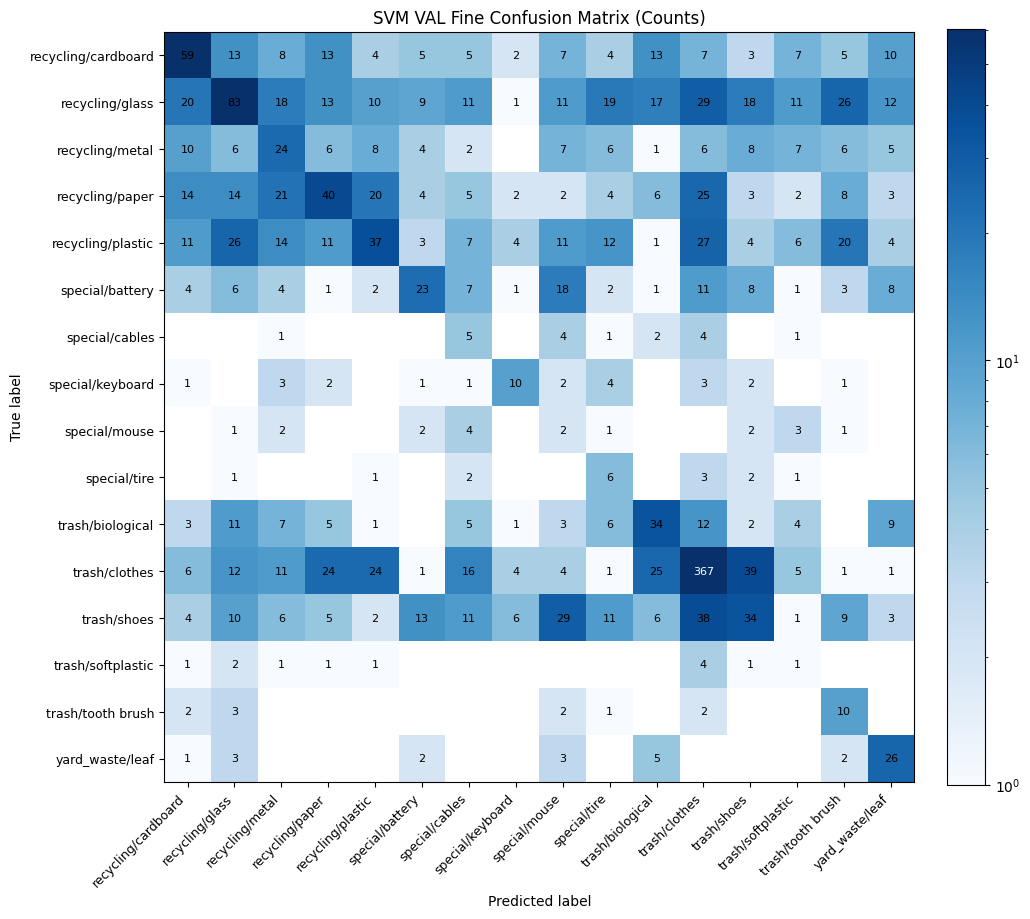

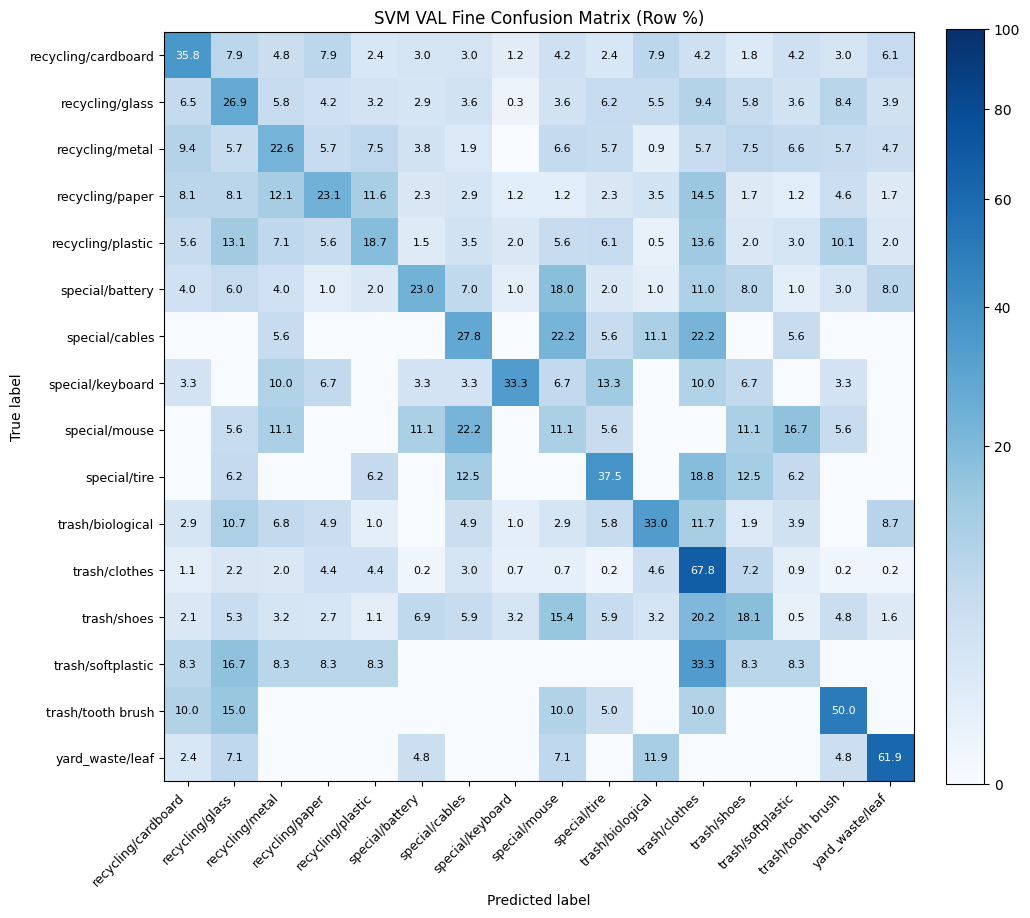


=== SVM VAL Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.74      0.53      0.62       950
     special       0.27      0.53      0.35       182
       trash       0.65      0.69      0.67       864
  yard_waste       0.32      0.62      0.42        42

    accuracy                           0.60      2038
   macro avg       0.49      0.59      0.52      2038
weighted avg       0.65      0.60      0.61      2038



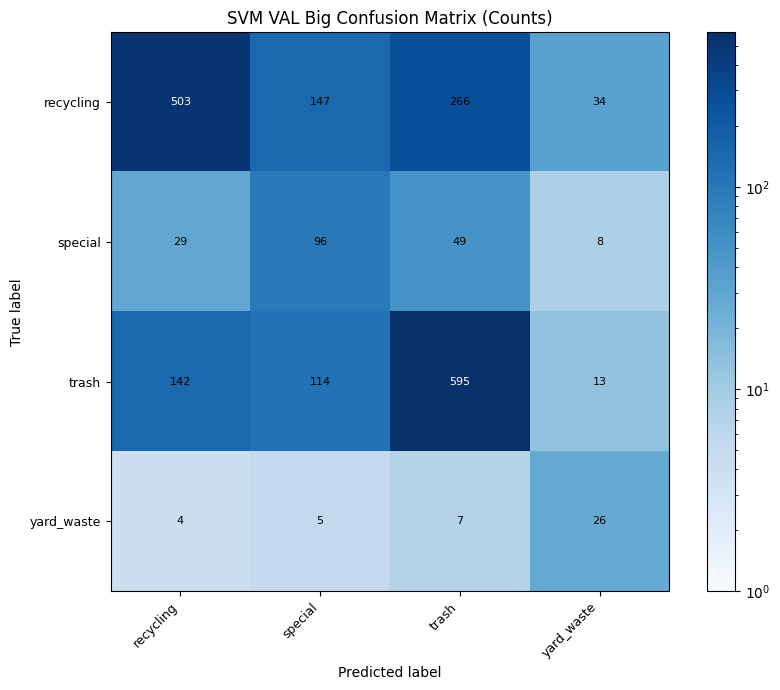

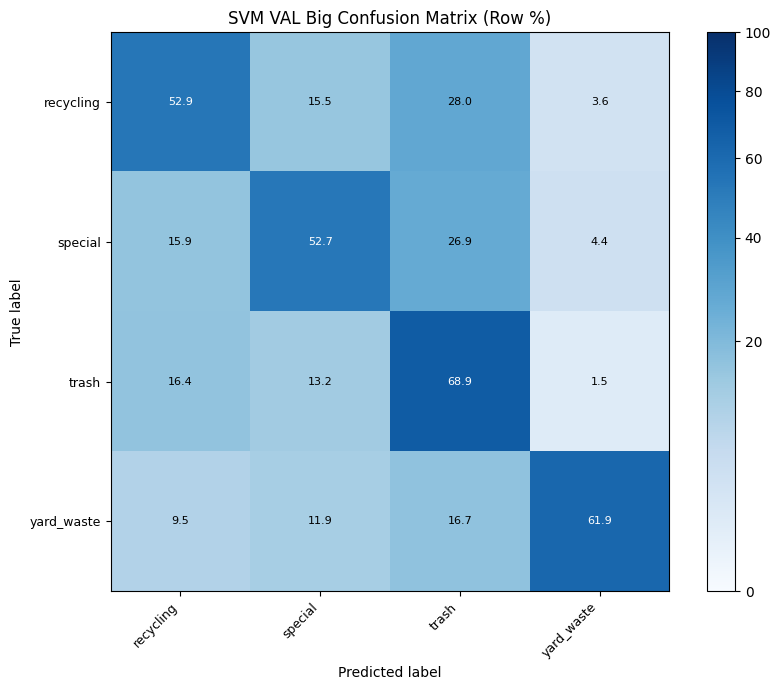


######## SVM TEST SET EVAL ########

=== SVM TEST Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.00      0.00      0.00        12
    recycling/glass       0.14      0.55      0.22        11
    recycling/metal       0.00      0.00      0.00        10
    recycling/paper       0.29      0.30      0.30        33
  recycling/plastic       0.00      0.00      0.00        23
    special/battery       0.00      0.00      0.00        13
     special/cables       0.08      0.08      0.08        12
   special/keyboard       0.00      0.00      0.00         9
      special/mouse       0.00      0.00      0.00        10
       special/tire       0.38      0.18      0.24        17
   trash/biological       0.12      0.20      0.15        10
      trash/clothes       0.09      0.38      0.14        16
        trash/shoes       0.15      0.07      0.10        28
  trash/softplastic       0.00      0.00      0.00        13
  trash/to

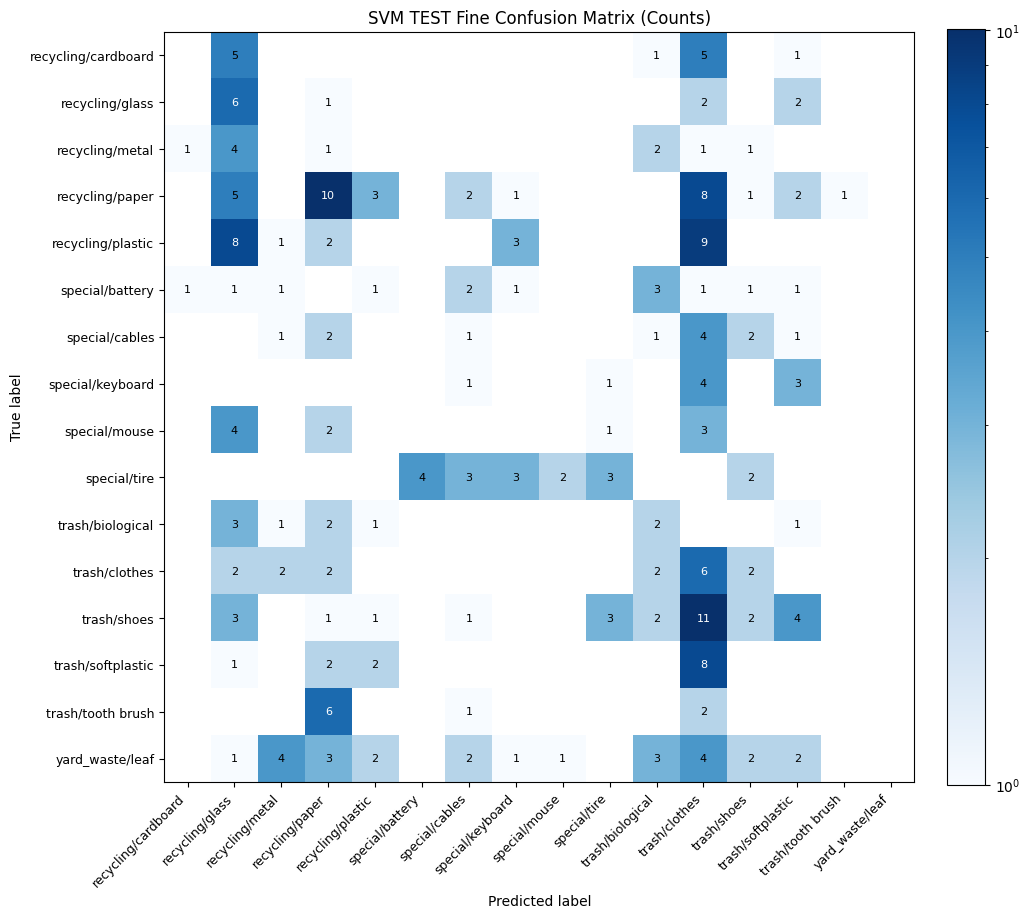

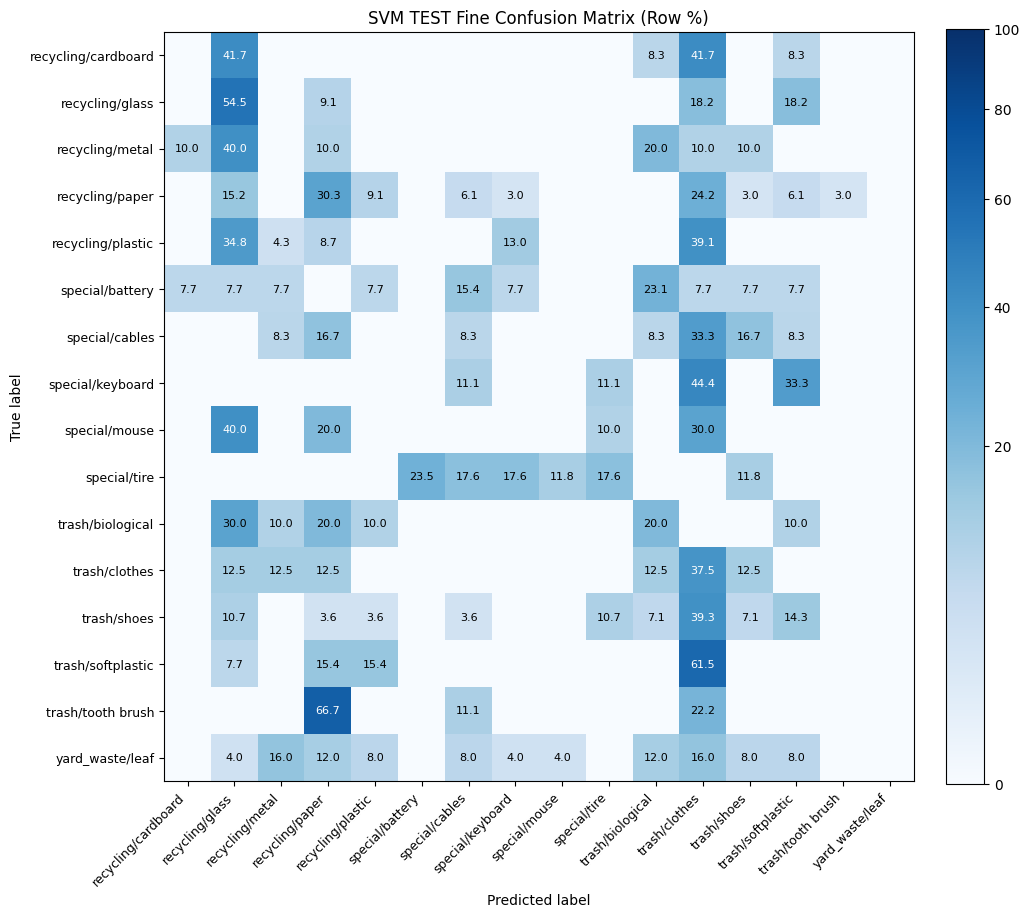


=== SVM TEST Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.47      0.53      0.50        89
     special       0.59      0.36      0.45        61
       trash       0.37      0.55      0.44        76
  yard_waste       0.00      0.00      0.00        25

    accuracy                           0.44       251
   macro avg       0.36      0.36      0.35       251
weighted avg       0.42      0.44      0.42       251



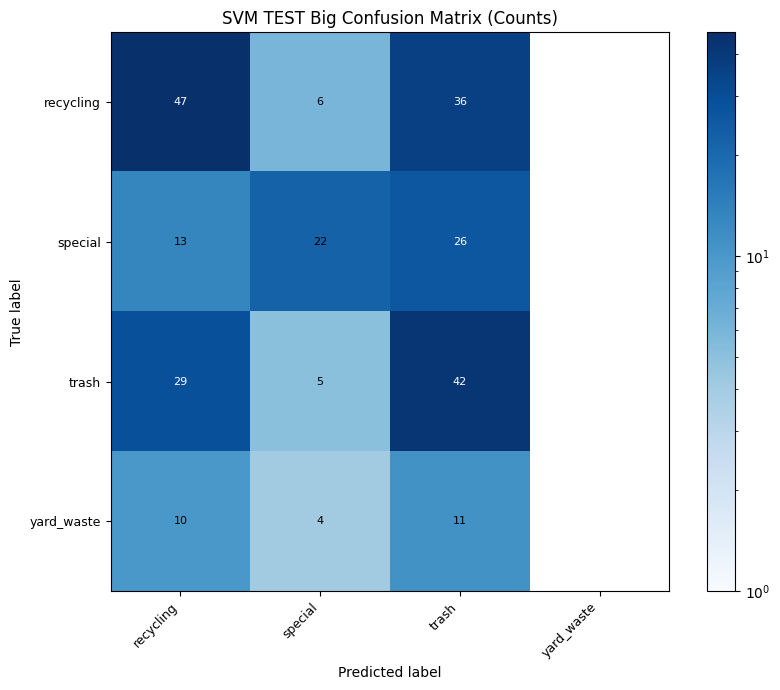

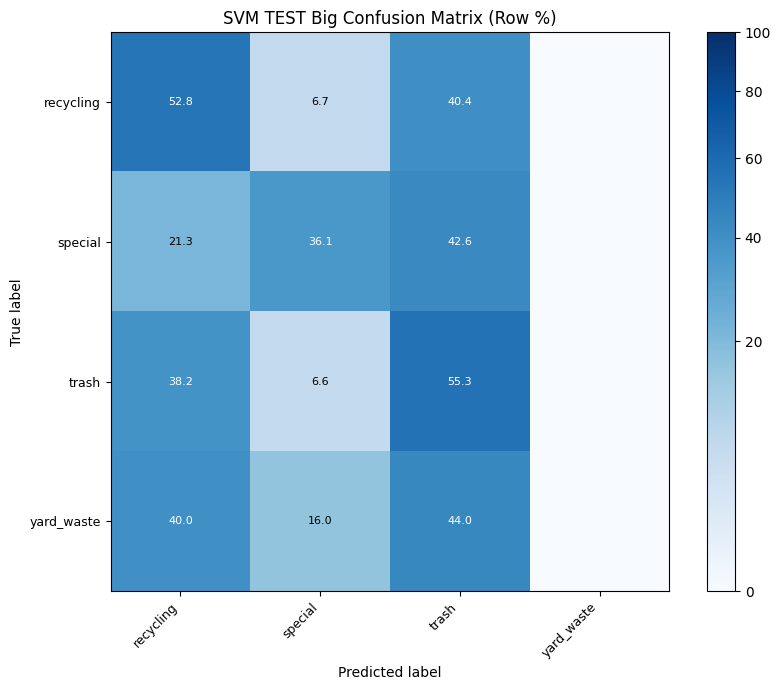


######## CNN VAL SET EVAL ########

=== CNN VAL Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.53      0.62      0.57       165
    recycling/glass       0.65      0.48      0.55       308
    recycling/metal       0.38      0.25      0.31       106
    recycling/paper       0.50      0.50      0.50       173
  recycling/plastic       0.55      0.39      0.46       198
    special/battery       0.42      0.75      0.54       100
     special/cables       1.00      0.06      0.11        18
   special/keyboard       1.00      0.13      0.24        30
      special/mouse       0.00      0.00      0.00        18
       special/tire       0.50      0.31      0.38        16
   trash/biological       0.54      0.55      0.55       103
      trash/clothes       0.64      0.87      0.74       541
        trash/shoes       0.46      0.36      0.40       188
  trash/softplastic       0.00      0.00      0.00        12
  trash/toot

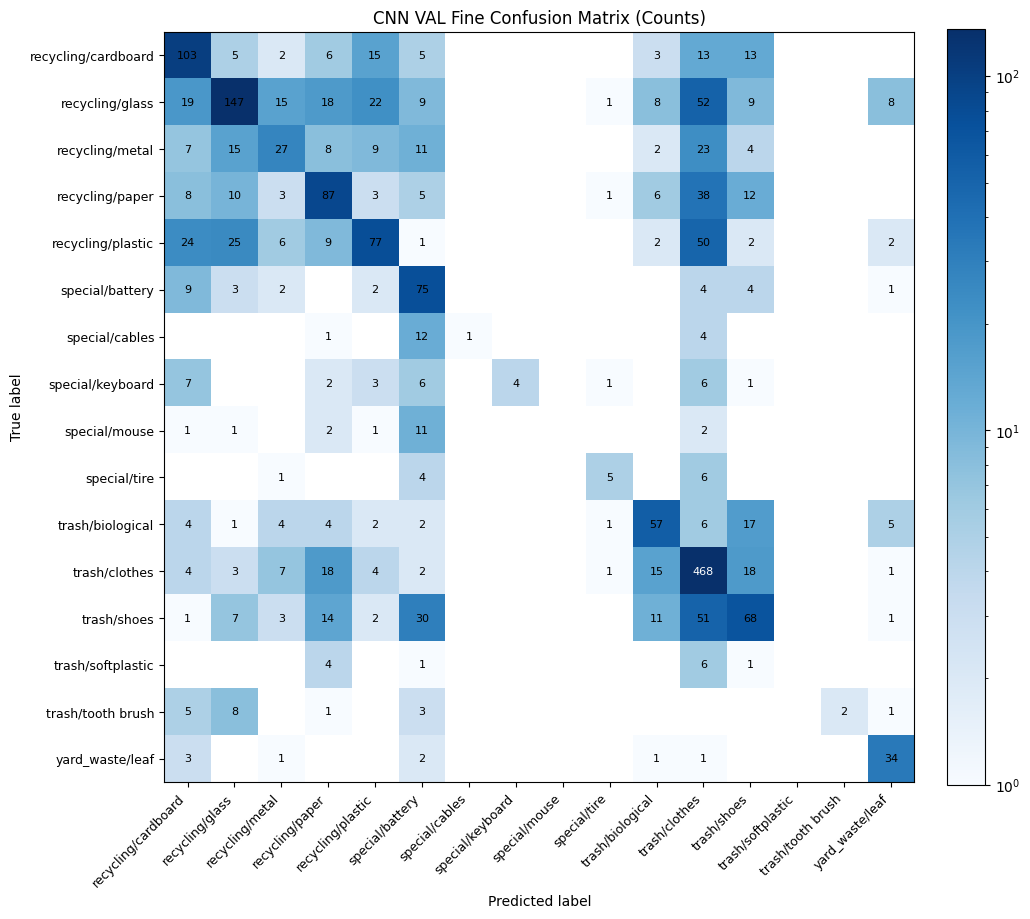

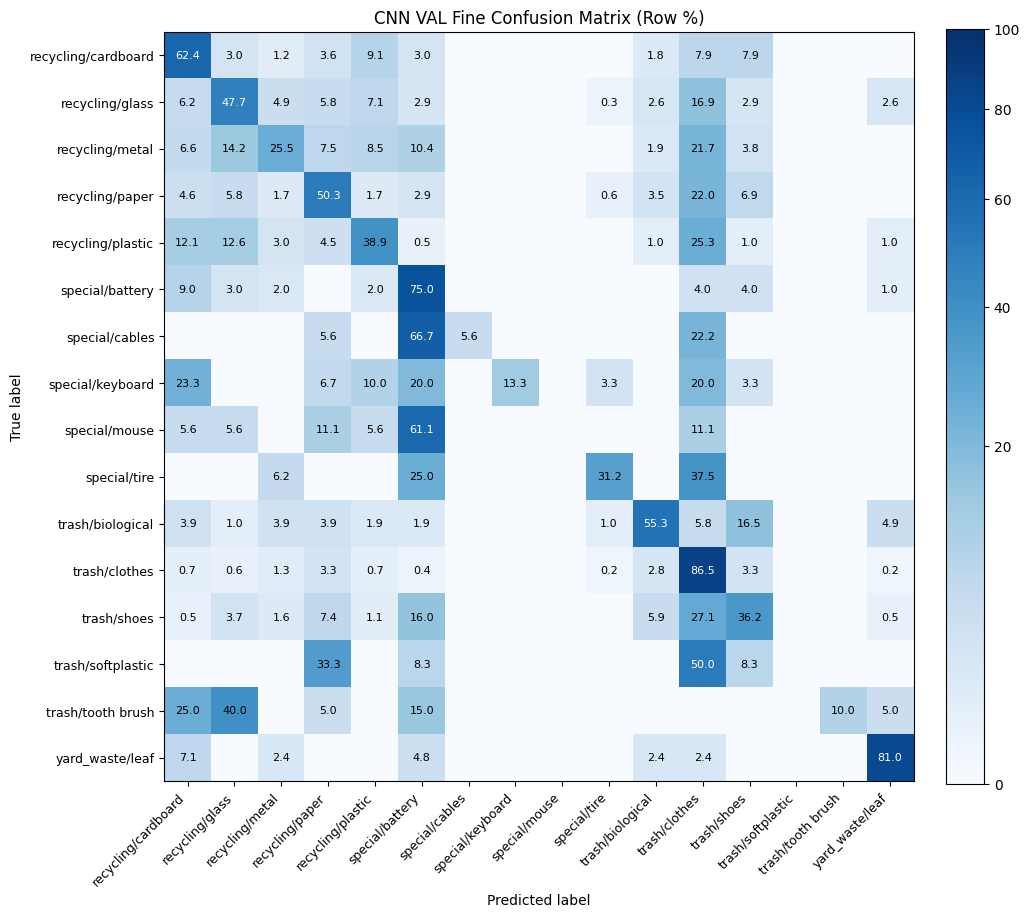


=== CNN VAL Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.83      0.71      0.76       950
     special       0.61      0.65      0.63       182
       trash       0.73      0.83      0.78       864
  yard_waste       0.64      0.81      0.72        42

    accuracy                           0.76      2038
   macro avg       0.70      0.75      0.72      2038
weighted avg       0.77      0.76      0.76      2038



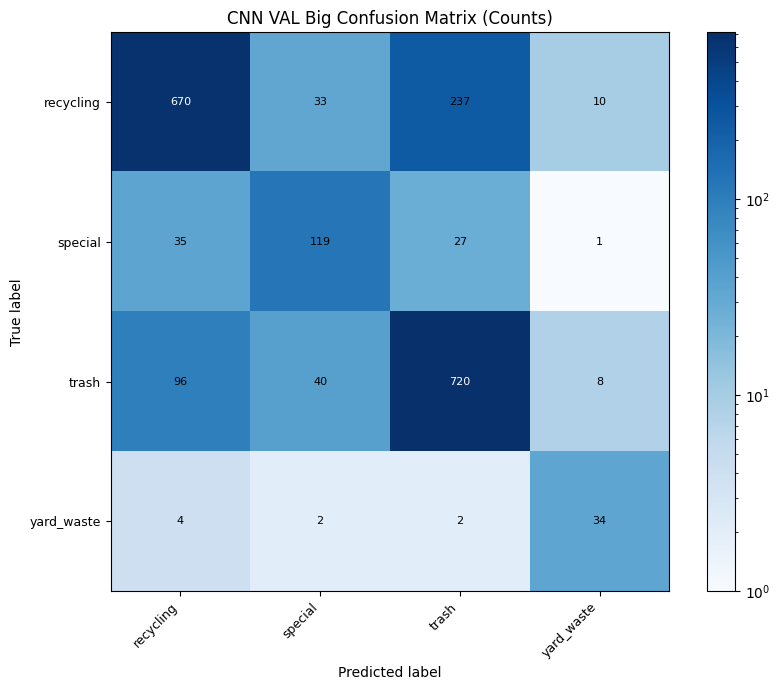

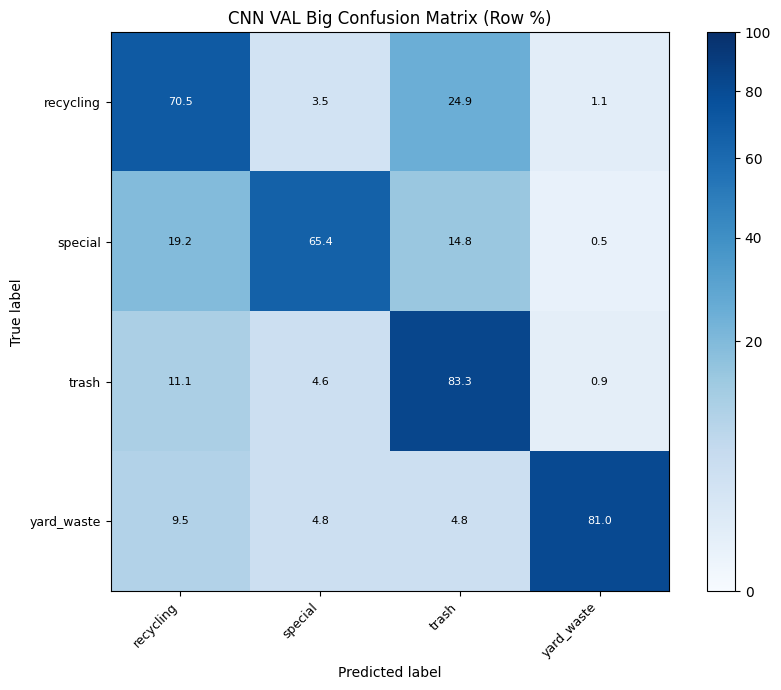


######## CNN TEST SET EVAL ########

=== CNN TEST Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.00      0.00      0.00        12
    recycling/glass       0.75      0.27      0.40        11
    recycling/metal       0.00      0.00      0.00        10
    recycling/paper       0.11      0.09      0.10        33
  recycling/plastic       0.00      0.00      0.00        23
    special/battery       0.00      0.00      0.00        13
     special/cables       0.00      0.00      0.00        12
   special/keyboard       0.00      0.00      0.00         9
      special/mouse       0.00      0.00      0.00        10
       special/tire       0.00      0.00      0.00        17
   trash/biological       0.30      0.30      0.30        10
      trash/clothes       0.08      0.75      0.14        16
        trash/shoes       0.19      0.14      0.16        28
  trash/softplastic       0.00      0.00      0.00        13
  trash/to

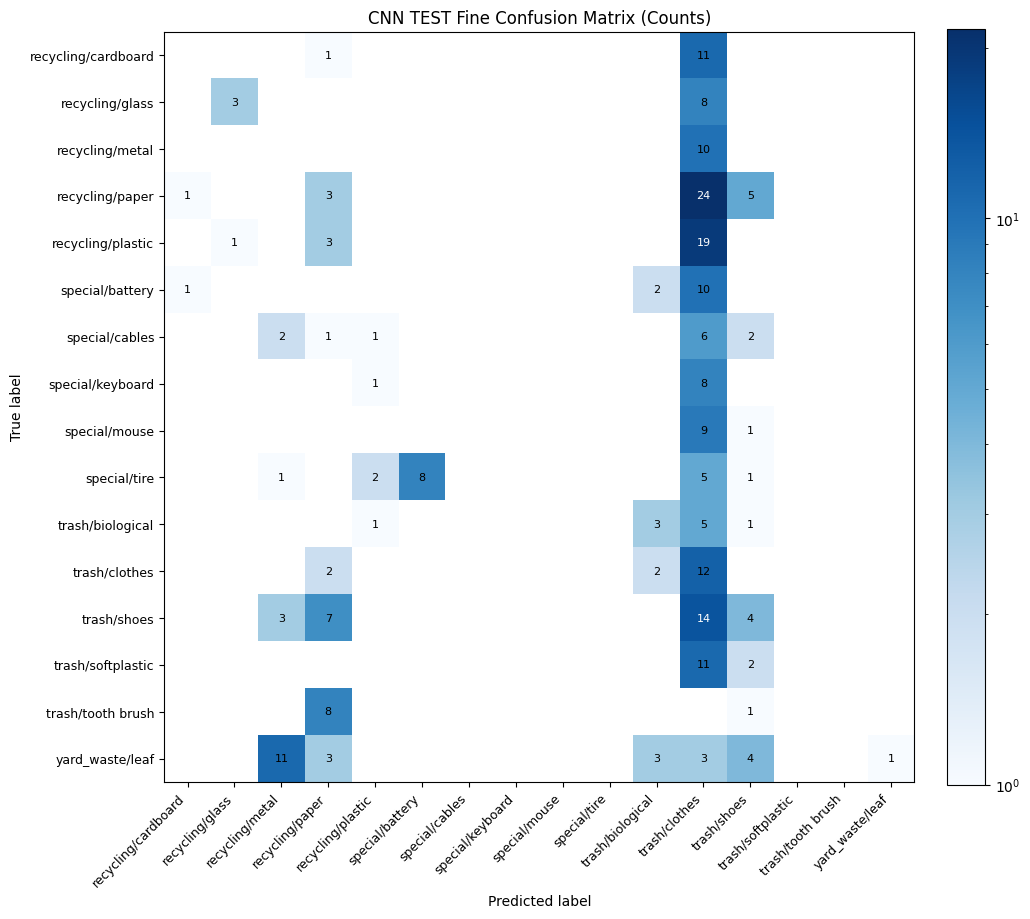

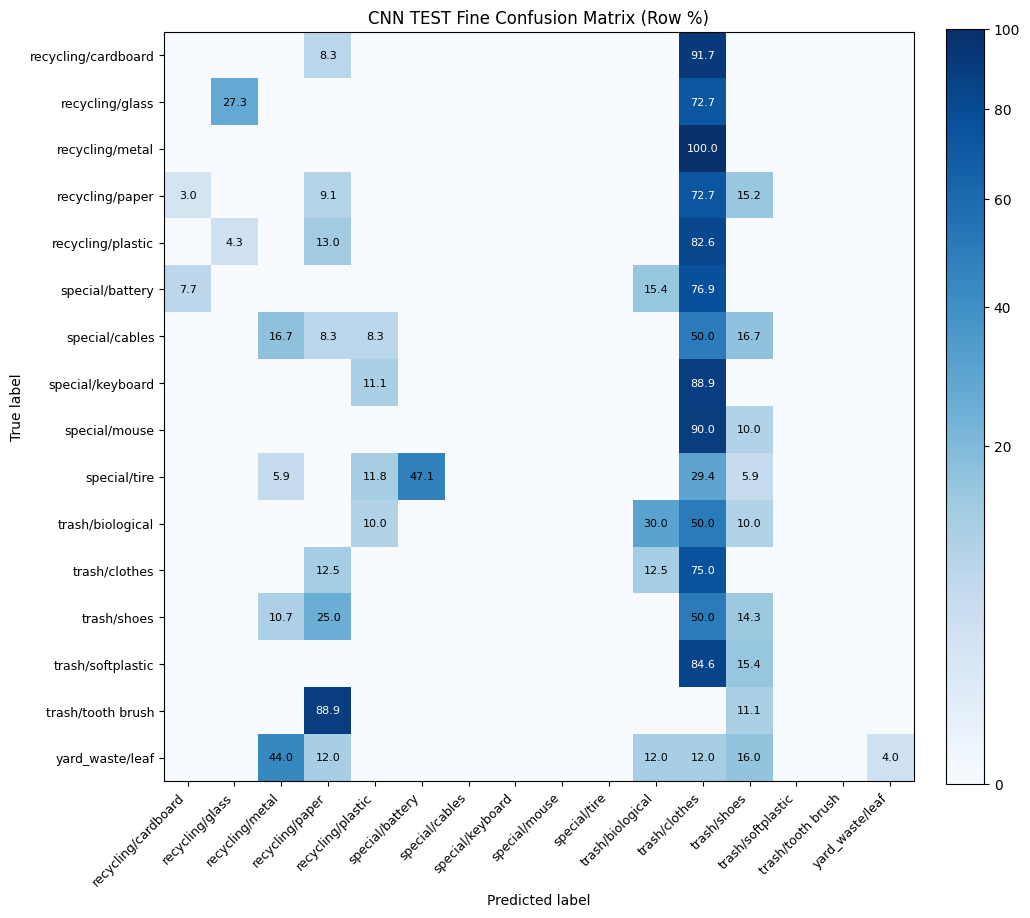


=== CNN TEST Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.21      0.13      0.17        89
     special       1.00      0.13      0.23        61
       trash       0.30      0.72      0.42        76
  yard_waste       1.00      0.04      0.08        25

    accuracy                           0.30       251
   macro avg       0.63      0.26      0.22       251
weighted avg       0.51      0.30      0.25       251



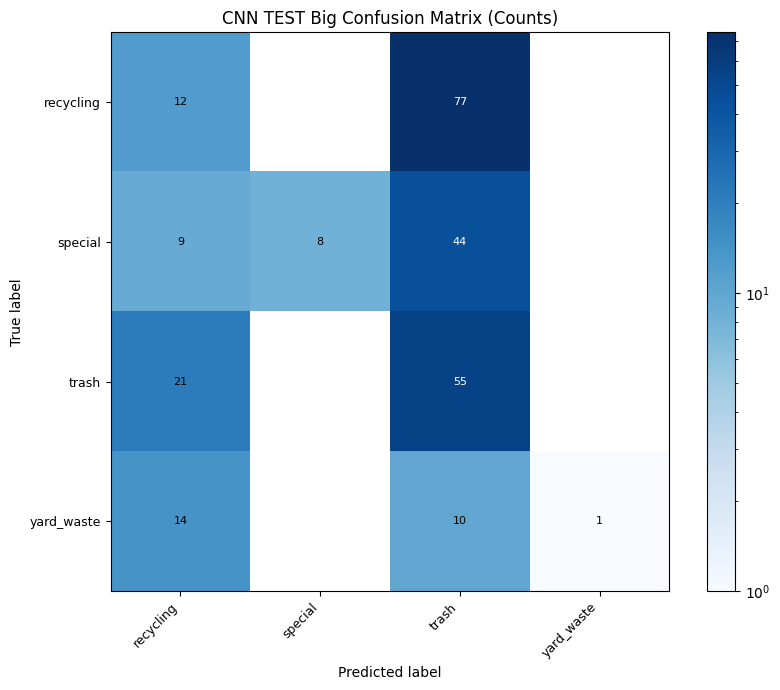

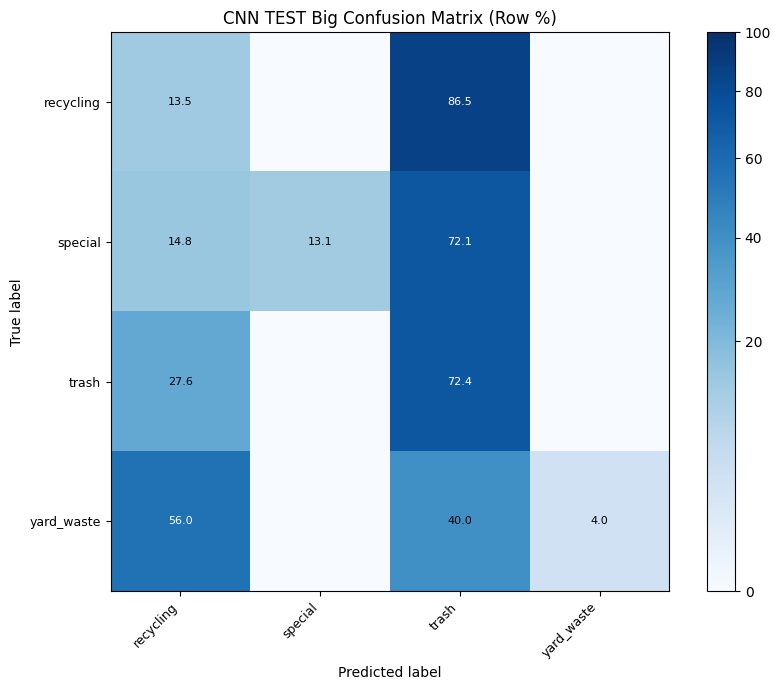


######## ResNet VAL SET EVAL ########

=== VAL Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.97      0.93      0.95       165
    recycling/glass       0.95      0.95      0.95       308
    recycling/metal       0.89      0.92      0.90       106
    recycling/paper       0.92      0.95      0.93       173
  recycling/plastic       0.95      0.91      0.93       198
    special/battery       0.95      0.98      0.97       100
     special/cables       0.74      0.78      0.76        18
   special/keyboard       1.00      0.93      0.97        30
      special/mouse       0.86      1.00      0.92        18
       special/tire       1.00      1.00      1.00        16
   trash/biological       0.96      0.99      0.98       103
      trash/clothes       0.99      0.98      0.99       541
        trash/shoes       0.96      0.97      0.97       188
  trash/softplastic       0.78      0.58      0.67        12
  trash/tooth

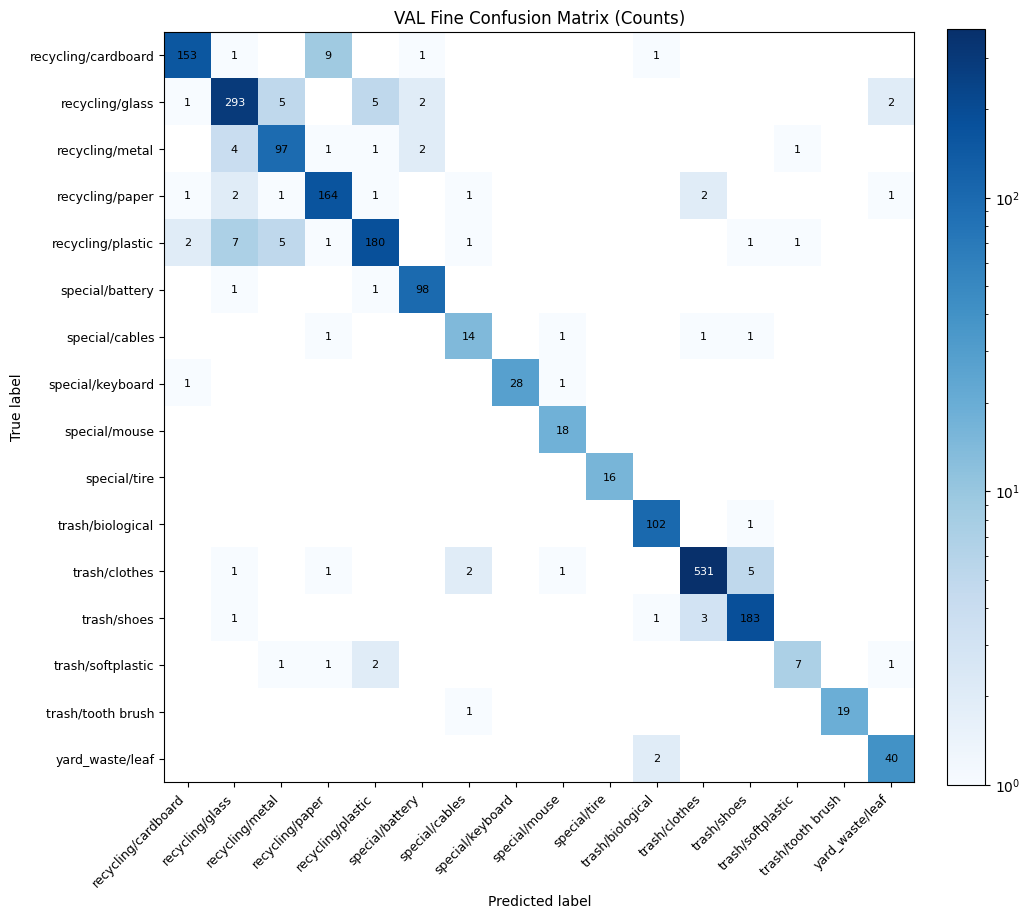

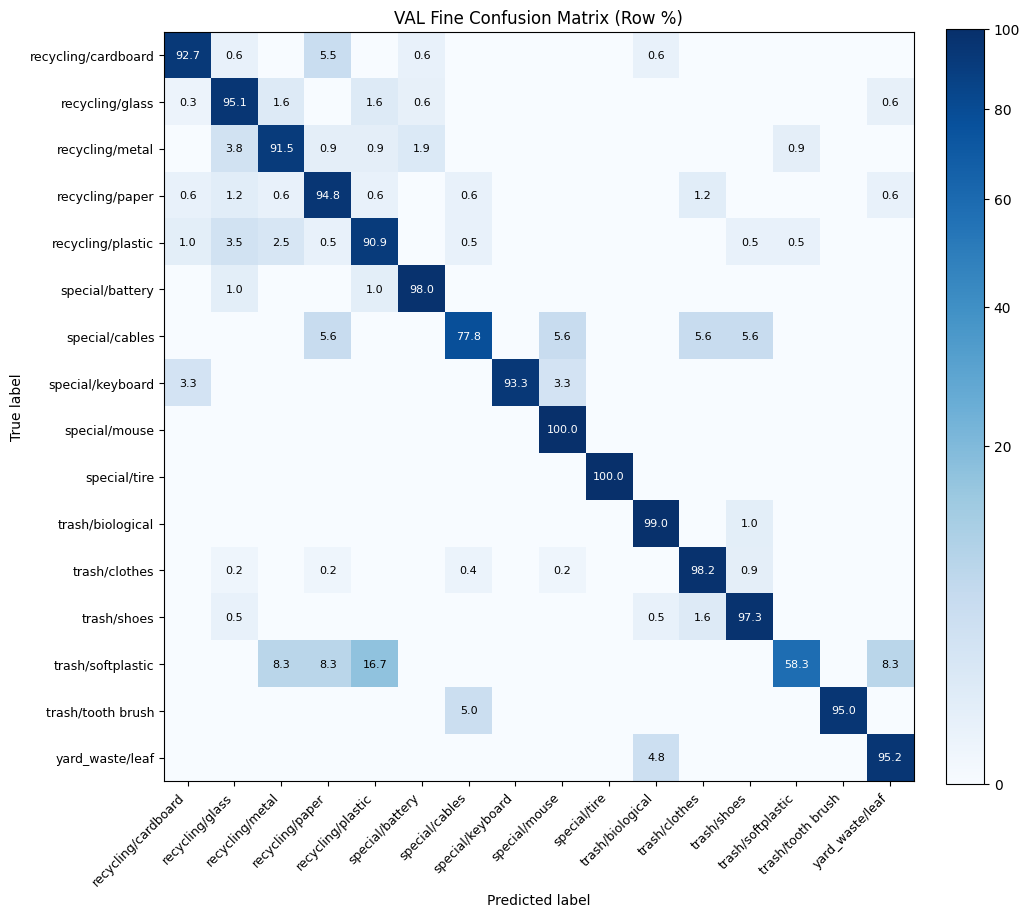


=== VAL Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.99      0.98      0.99       950
     special       0.94      0.97      0.95       182
       trash       0.99      0.99      0.99       864
  yard_waste       0.91      0.95      0.93        42

    accuracy                           0.98      2038
   macro avg       0.96      0.97      0.96      2038
weighted avg       0.98      0.98      0.98      2038



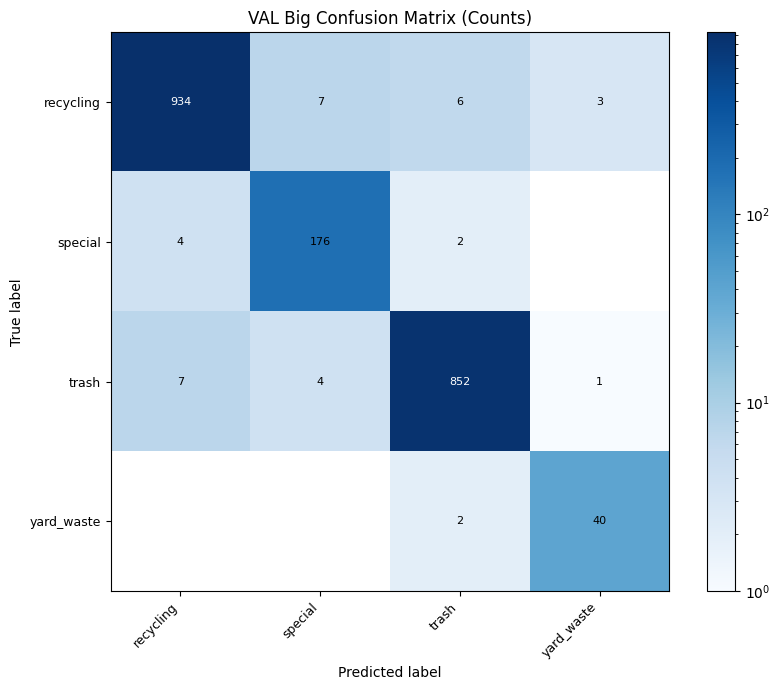

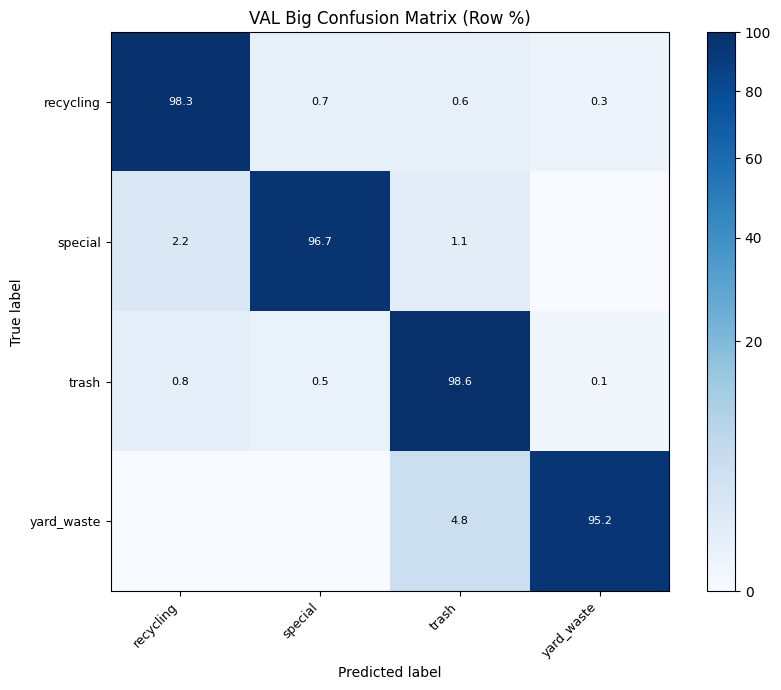


######## ResNet TEST SET EVAL ########

=== TEST Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.60      0.75      0.67        12
    recycling/glass       0.24      0.82      0.38        11
    recycling/metal       0.40      0.40      0.40        10
    recycling/paper       0.65      0.79      0.71        33
  recycling/plastic       0.52      0.48      0.50        23
    special/battery       0.78      0.54      0.64        13
     special/cables       0.56      0.42      0.48        12
   special/keyboard       0.82      1.00      0.90         9
      special/mouse       0.71      1.00      0.83        10
       special/tire       1.00      0.82      0.90        17
   trash/biological       0.50      0.10      0.17        10
      trash/clothes       0.81      0.81      0.81        16
        trash/shoes       0.89      0.89      0.89        28
  trash/softplastic       0.50      0.46      0.48        13
  trash/too

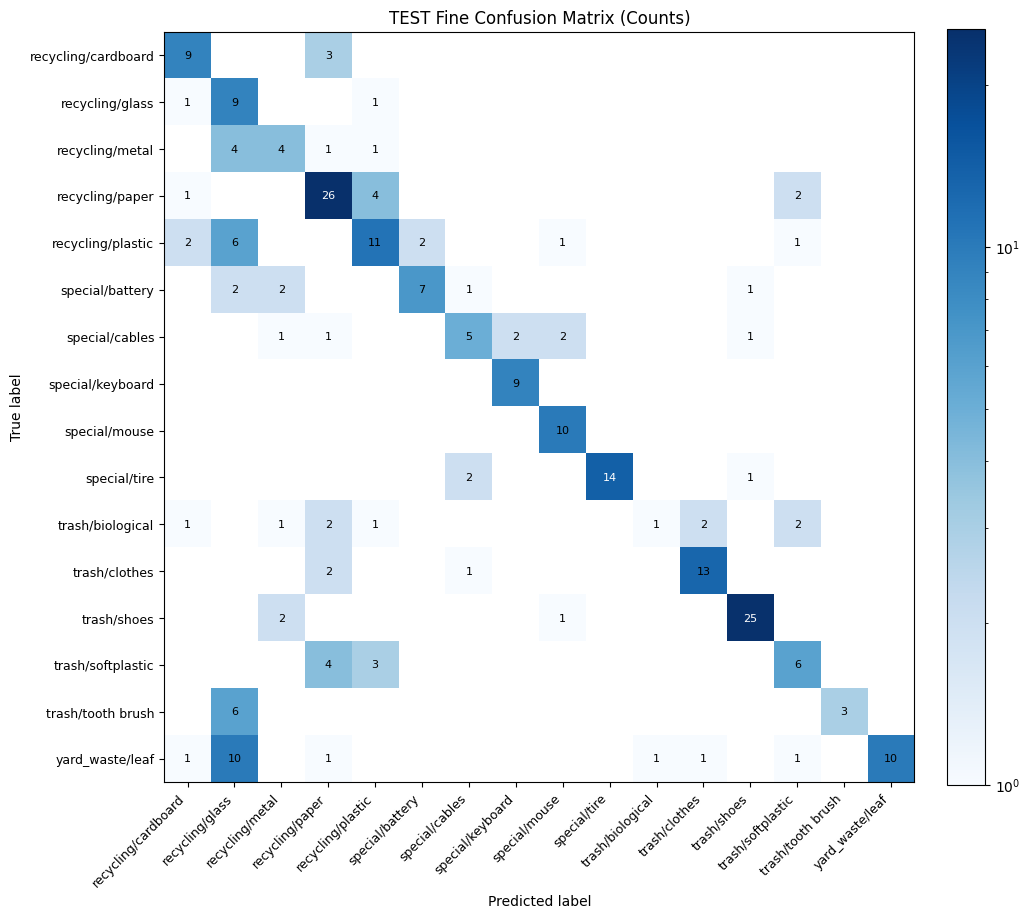

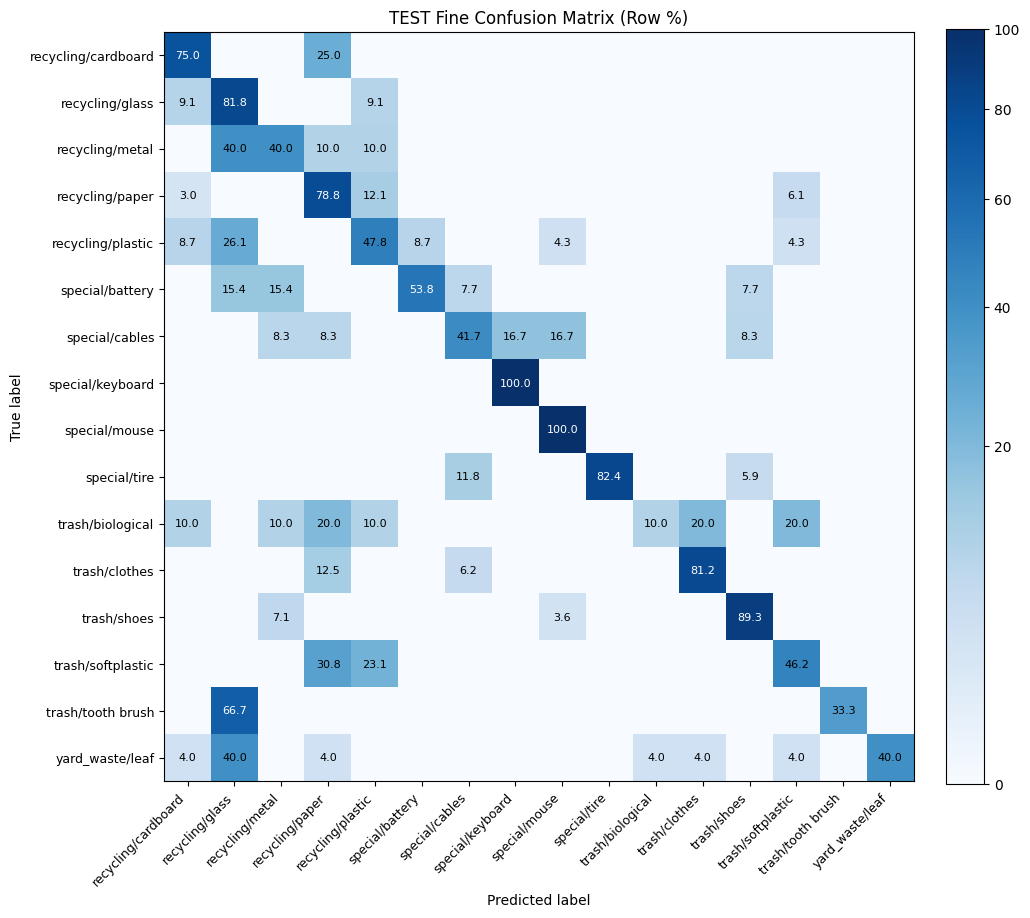


=== TEST Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.67      0.93      0.78        89
     special       0.91      0.85      0.88        61
       trash       0.85      0.68      0.76        76
  yard_waste       1.00      0.40      0.57        25

    accuracy                           0.78       251
   macro avg       0.86      0.72      0.75       251
weighted avg       0.82      0.78      0.78       251



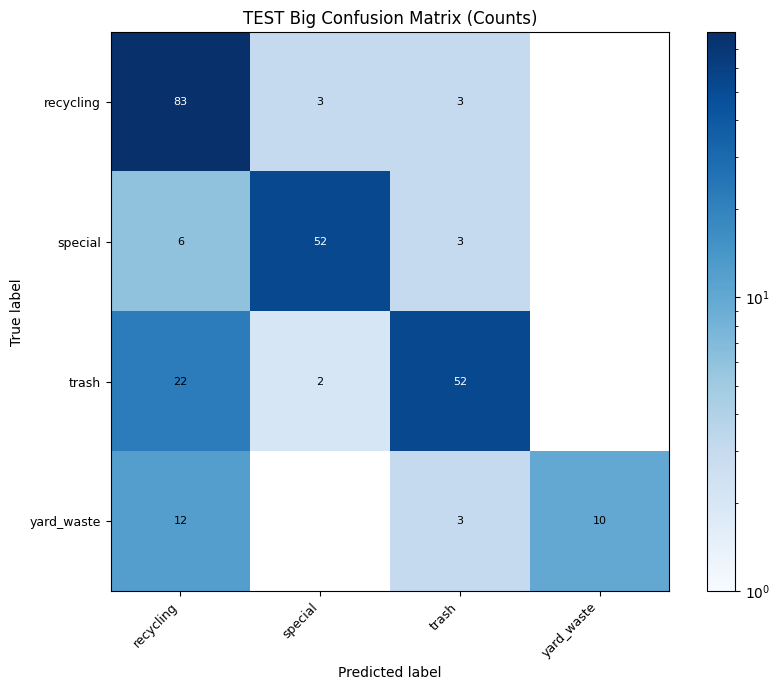

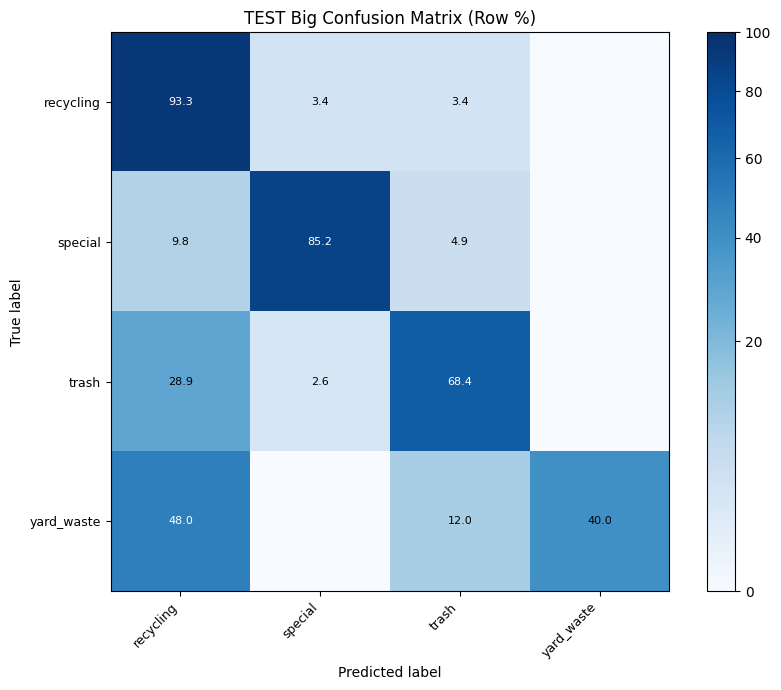


######## MobileNet VAL SET EVAL ########

=== MobileNet VAL Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.97      0.95      0.96       165
    recycling/glass       0.96      0.95      0.96       308
    recycling/metal       0.87      0.91      0.89       106
    recycling/paper       0.93      0.96      0.95       173
  recycling/plastic       0.95      0.93      0.94       198
    special/battery       0.99      0.93      0.96       100
     special/cables       0.70      0.89      0.78        18
   special/keyboard       1.00      0.97      0.98        30
      special/mouse       0.81      0.94      0.87        18
       special/tire       1.00      1.00      1.00        16
   trash/biological       0.96      0.99      0.98       103
      trash/clothes       0.99      0.99      0.99       541
        trash/shoes       0.96      0.97      0.97       188
  trash/softplastic       1.00      0.67      0.80        12


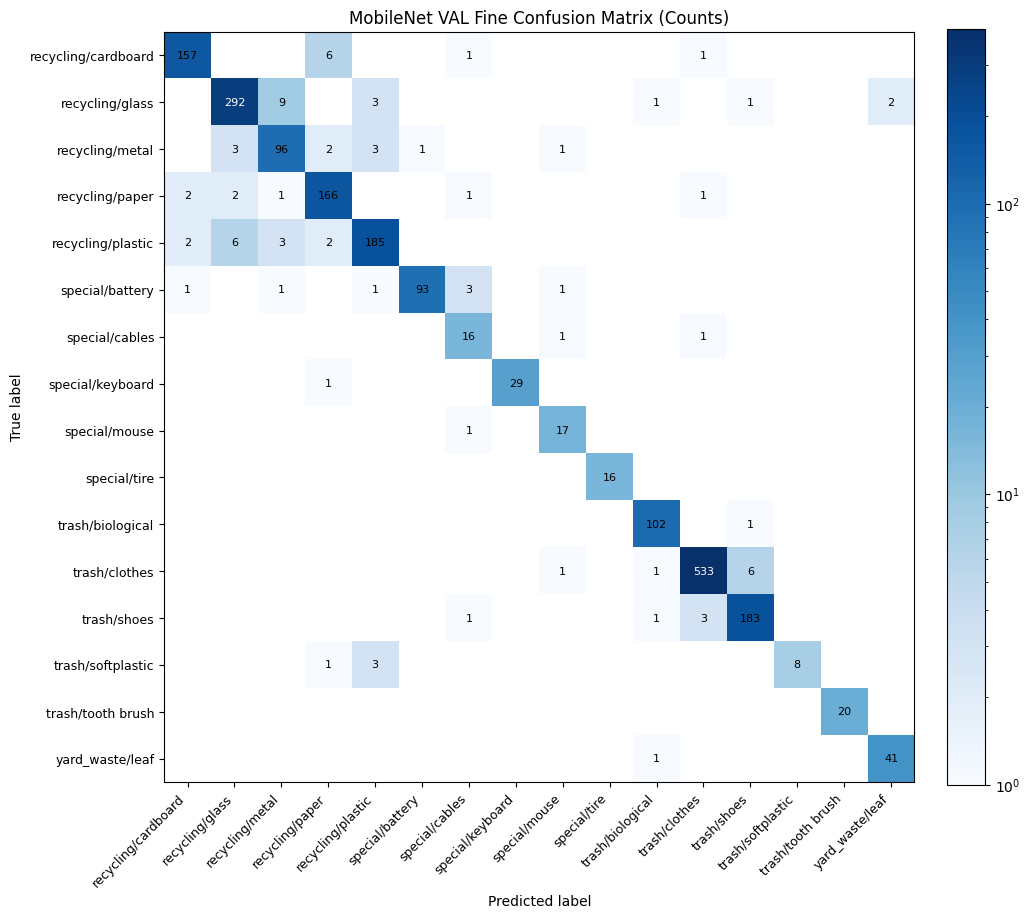

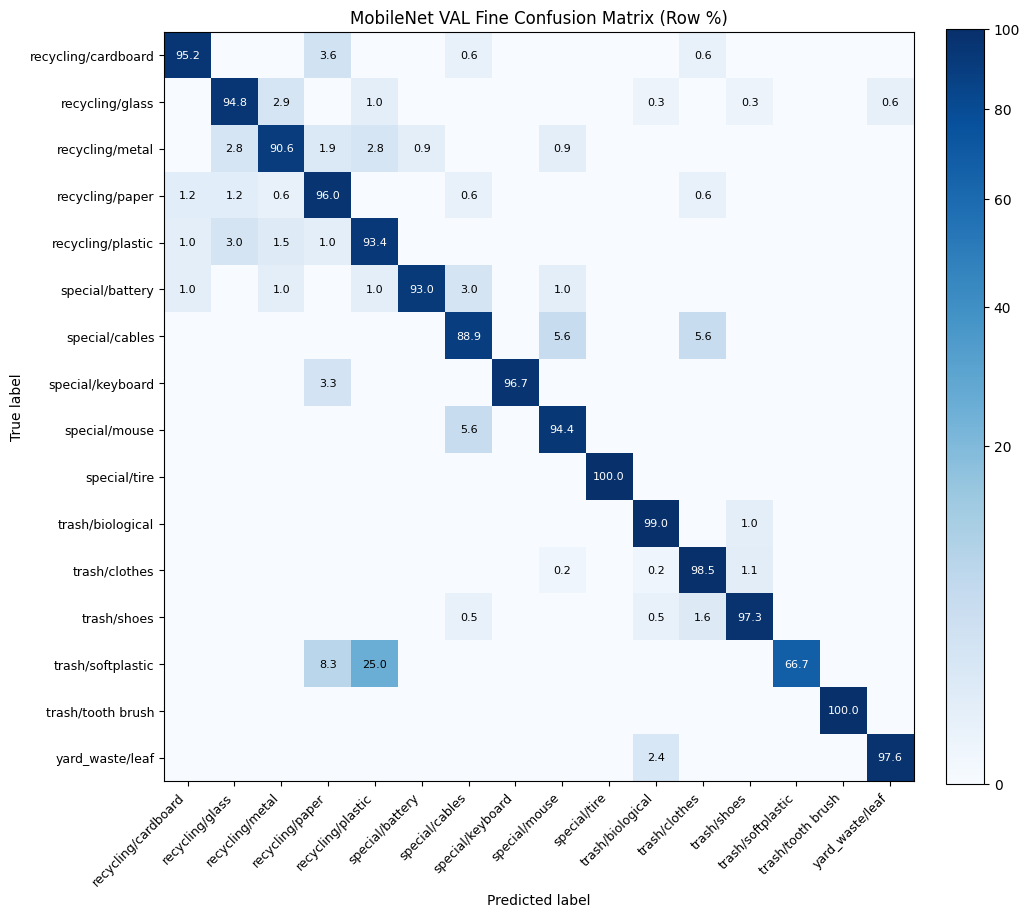


=== MobileNet VAL Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.99      0.99      0.99       950
     special       0.97      0.97      0.97       182
       trash       0.99      0.99      0.99       864
  yard_waste       0.95      0.98      0.96        42

    accuracy                           0.99      2038
   macro avg       0.98      0.98      0.98      2038
weighted avg       0.99      0.99      0.99      2038



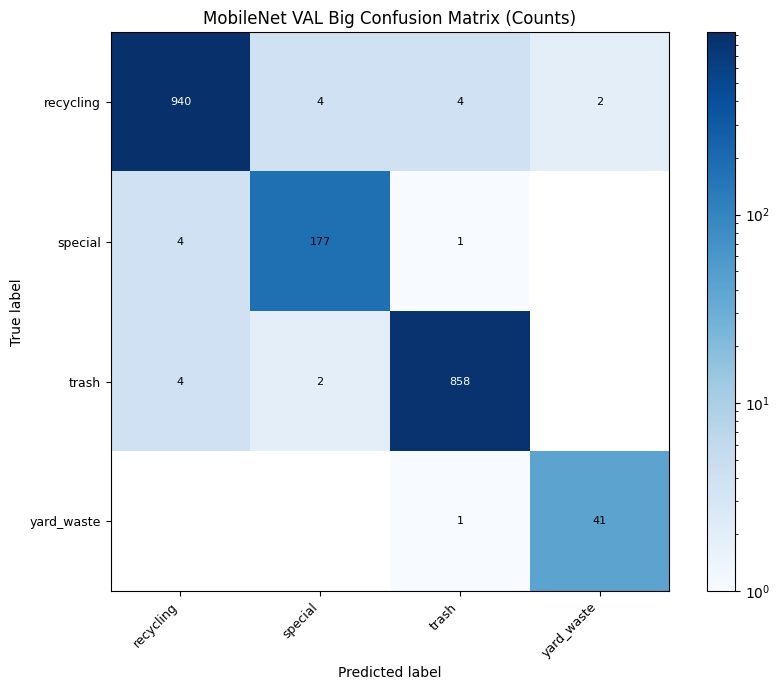

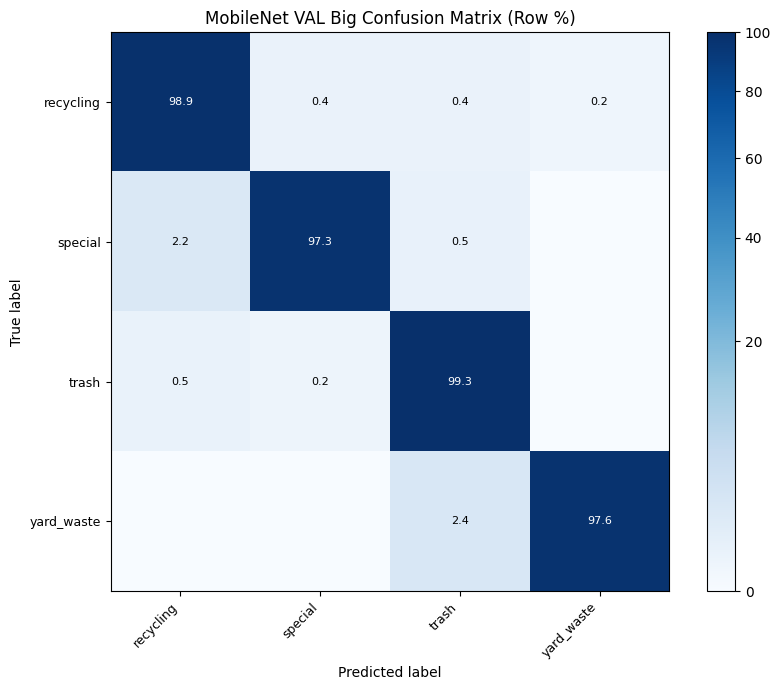


######## MobileNet TEST SET EVAL ########

=== MobileNet TEST Fine-class Report  ===
                     precision    recall  f1-score   support

recycling/cardboard       0.73      0.67      0.70        12
    recycling/glass       0.36      0.82      0.50        11
    recycling/metal       0.23      0.30      0.26        10
    recycling/paper       0.85      0.70      0.77        33
  recycling/plastic       0.50      0.78      0.61        23
    special/battery       1.00      0.46      0.63        13
     special/cables       0.75      0.50      0.60        12
   special/keyboard       0.69      1.00      0.82         9
      special/mouse       0.83      1.00      0.91        10
       special/tire       0.94      1.00      0.97        17
   trash/biological       0.75      0.90      0.82        10
      trash/clothes       0.48      1.00      0.65        16
        trash/shoes       0.92      0.82      0.87        28
  trash/softplastic       0.60      0.23      0.33        1

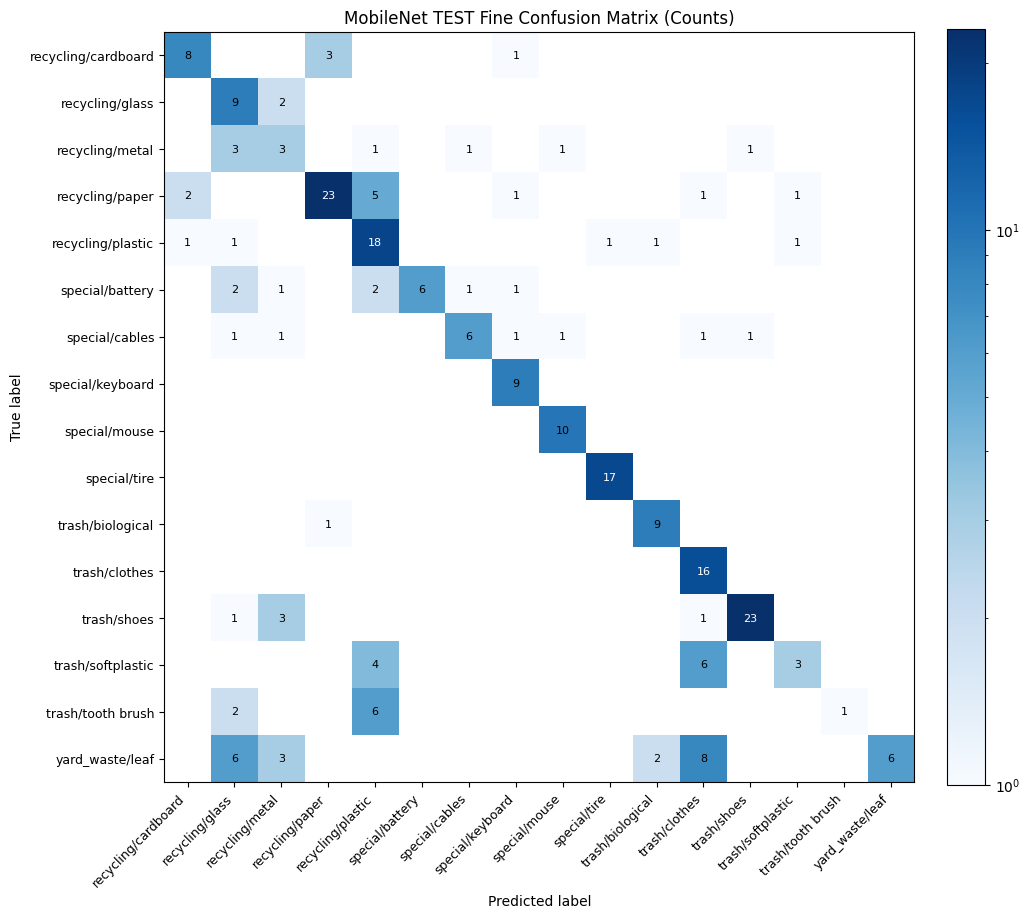

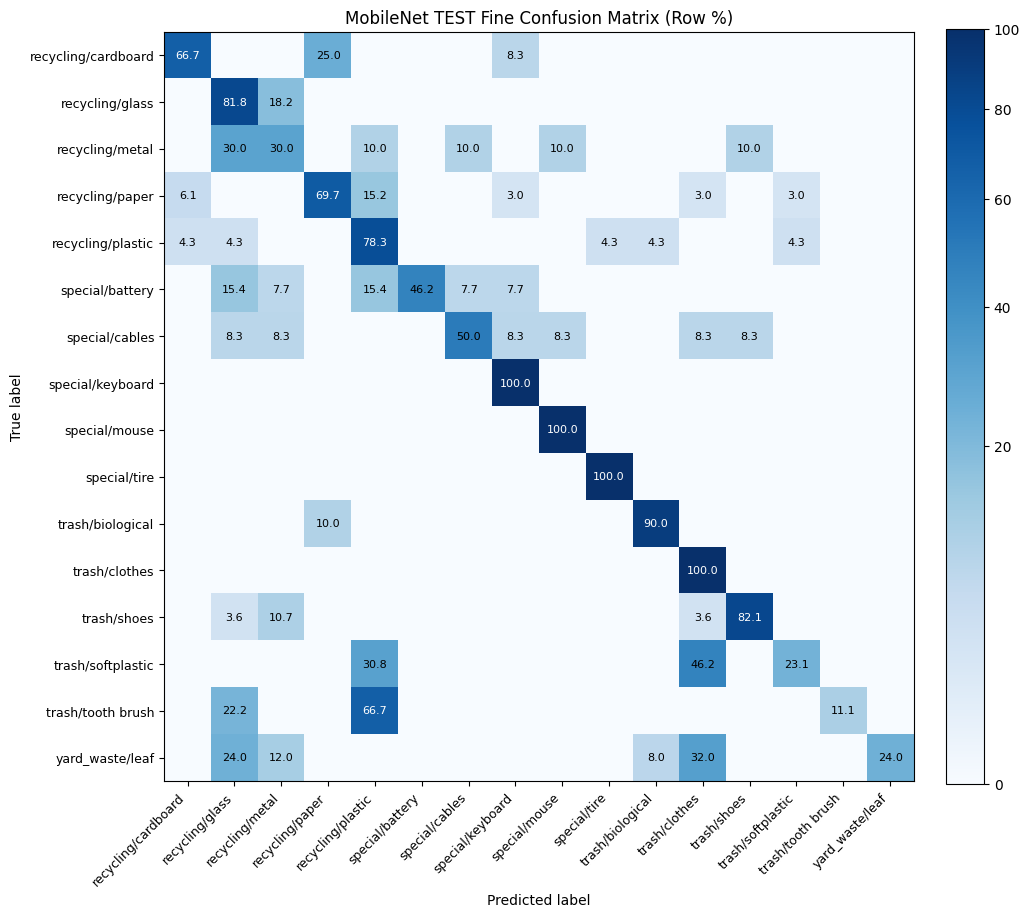


=== MobileNet TEST Big-class Report  ===
              precision    recall  f1-score   support

   recycling       0.71      0.89      0.79        89
     special       0.91      0.85      0.88        61
       trash       0.78      0.78      0.78        76
  yard_waste       1.00      0.24      0.39        25

    accuracy                           0.78       251
   macro avg       0.85      0.69      0.71       251
weighted avg       0.81      0.78      0.77       251



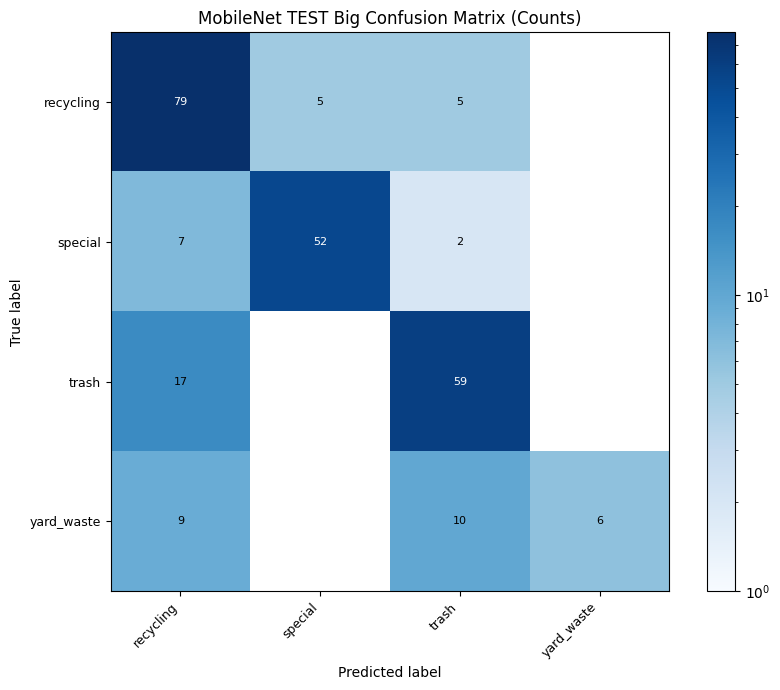

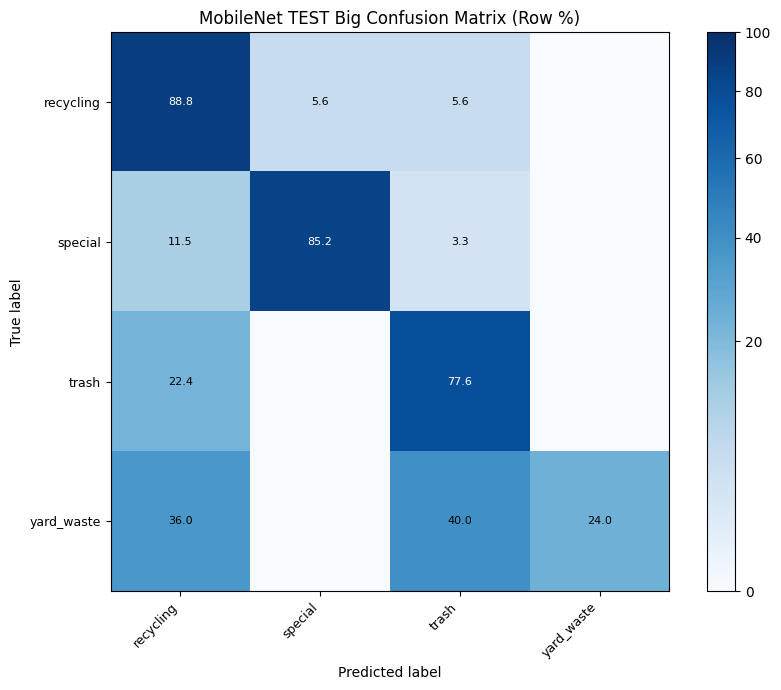

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import PowerNorm, LogNorm
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def collect_fine_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []

    for images, fine_labels, _ in loader:
        images = images.to(device)
        outputs = model(images)
        pred = outputs.argmax(dim=1).cpu().numpy()

        y_true.extend(fine_labels.numpy())
        y_pred.extend(pred)

    return np.array(y_true), np.array(y_pred)


def _plot_confusion_matrix(cm, class_names, title, normalize=False,
                           cmap="Blues", use_log_for_counts=True, vmax_percentile=99):

    cm_plot = cm.astype(np.float64)

    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums != 0) * 100.0

    n = len(class_names)

    fig_w = min(18, max(10, 0.65 * n))
    fig_h = min(18, max(7,  0.60 * n))
    plt.figure(figsize=(fig_w, fig_h))

    if normalize:

        vmax = 100.0
        norm = PowerNorm(gamma=0.5, vmin=0.0, vmax=vmax)
        im = plt.imshow(cm_plot, interpolation="nearest", cmap=cmap, norm=norm)
    else:

        nonzero = cm_plot[cm_plot > 0]
        vmax = np.percentile(nonzero, vmax_percentile) if nonzero.size else 1.0

        if use_log_for_counts:

            masked = np.ma.masked_where(cm_plot == 0, cm_plot)
            norm = LogNorm(vmin=1, vmax=max(1, vmax))
            im = plt.imshow(masked, interpolation="nearest", cmap=cmap, norm=norm)
        else:

            norm = PowerNorm(gamma=0.5, vmin=0.0, vmax=vmax)
            im = plt.imshow(cm_plot, interpolation="nearest", cmap=cmap, norm=norm)

    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    tick_marks = np.arange(n)
    plt.xticks(tick_marks, class_names, rotation=45, ha="right", fontsize=9)
    plt.yticks(tick_marks, class_names, fontsize=9)


    display_max = np.nanmax(cm_plot) if normalize else (np.nanmax(cm_plot[cm_plot > 0]) if np.any(cm_plot > 0) else 1.0)
    thresh = display_max * 0.5

    for i in range(n):
        for j in range(n):
            val = cm_plot[i, j]
            if normalize:
                text = f"{val:.1f}"
                show = (val > 0)
            else:
                text = str(int(cm[i, j]))
                show = (cm[i, j] > 0)

            if show:
                plt.text(j, i, text,
                         ha="center", va="center",
                         fontsize=8,
                         color="white" if val > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


def evaluate_report(y_fine_true, y_fine_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name=""):

    fine_names = [fine_idx_to_name[i] for i in range(len(fine_idx_to_name))]

    print(f"\n=== {set_name} Fine-class Report  ===")
    print(classification_report(y_fine_true, y_fine_pred, target_names=fine_names, zero_division=0))

    cm_fine = confusion_matrix(y_fine_true, y_fine_pred, labels=np.arange(len(fine_names)))
    _plot_confusion_matrix(cm_fine, fine_names, title=f"{set_name} Fine Confusion Matrix (Counts)", normalize=False)
    _plot_confusion_matrix(cm_fine, fine_names, title=f"{set_name} Fine Confusion Matrix (Row %)", normalize=True)

    y_big_true = np.array([fine_to_big[int(i)] for i in y_fine_true])
    y_big_pred = np.array([fine_to_big[int(i)] for i in y_fine_pred])

    big_names = [big_idx_to_name[i] for i in range(len(big_idx_to_name))]

    print(f"\n=== {set_name} Big-class Report  ===")
    print(classification_report(y_big_true, y_big_pred, target_names=big_names, zero_division=0))

    cm_big = confusion_matrix(y_big_true, y_big_pred, labels=np.arange(len(big_names)))
    _plot_confusion_matrix(cm_big, big_names, title=f"{set_name} Big Confusion Matrix (Counts)", normalize=False)
    _plot_confusion_matrix(cm_big, big_names, title=f"{set_name} Big Confusion Matrix (Row %)", normalize=True)

print("\n######## SVM VAL SET EVAL ########")
evaluate_report(svm_val_labels, svm_val_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="SVM VAL")

print("\n######## SVM TEST SET EVAL ########")
evaluate_report(svm_test_labels, svm_test_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="SVM TEST")

print("\n######## CNN VAL SET EVAL ########")
y_cnn_val_true, y_cnn_val_pred = collect_fine_preds(cnn_model, val_loader, device)
evaluate_report(y_cnn_val_true, y_cnn_val_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="CNN VAL")

print("\n######## CNN TEST SET EVAL ########")
y_cnn_test_true, y_cnn_test_pred = collect_fine_preds(cnn_model, test_loader, device)
evaluate_report(y_cnn_test_true, y_cnn_test_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="CNN TEST")

y_val_true, y_val_pred = collect_fine_preds(model, val_loader, device)
print("\n######## ResNet VAL SET EVAL ########")
evaluate_report(y_val_true, y_val_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="VAL")

y_test_true, y_test_pred = collect_fine_preds(model, test_loader, device)
print("\n######## ResNet TEST SET EVAL ########")
evaluate_report(y_test_true, y_test_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="TEST")

print("\n######## MobileNet VAL SET EVAL ########")
y_mb_val_true, y_mb_val_pred = collect_fine_preds(mobile_model, val_loader, device)
evaluate_report(y_mb_val_true, y_mb_val_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="MobileNet VAL")

print("\n######## MobileNet TEST SET EVAL ########")
y_mb_test_true, y_mb_test_pred = collect_fine_preds(mobile_model, test_loader, device)
evaluate_report(y_mb_test_true, y_mb_test_pred, fine_idx_to_name, fine_to_big, big_idx_to_name, set_name="MobileNet TEST")




In [20]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/Final" # @param {type:"string"}
NOTEBOOK_NAME = "Imagenet.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")

In [24]:
import time
import cv2
import torch.nn.functional as F
import io
import base64
from google.colab.output import eval_js
from IPython.display import display, Javascript

In [27]:
"""Webcam inference (optional, run manually in Colab/local)"""


def predict_single_pil(pil_img, model, transform, device):
    model.eval()
    with torch.no_grad():
        x = transform(pil_img).unsqueeze(0).to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0]
        fine_idx = torch.argmax(probs).item()
        big_idx = fine_to_big.get(fine_idx, -1)
        return fine_idx, big_idx, probs[fine_idx].item()


def run_webcam(model, device, window_name="Garbage classifier"):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open webcam")
        return
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(rgb)
            fine_idx, big_idx, prob = predict_single_pil(pil_img, model, val_test_transform, device)
            fine_name = fine_idx_to_name.get(fine_idx, "unknown")
            big_name = big_idx_to_name.get(big_idx, "unknown")
            text = f"{big_name} / {fine_name} ({prob*100:.1f}%)"
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(window_name, frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()

In [49]:
"""Colab camera capture (JS widget) for inference"""

def _colab_take_photo():
    js_code = r"""
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const btn = document.createElement('button');
      btn.textContent = '拍照';
      div.appendChild(video);
      div.appendChild(btn);
      document.body.appendChild(div);
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();
      await new Promise((resolve) => btn.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(t => t.stop());
      const data = canvas.toDataURL('image/png');
      div.remove();
      return data;
    }
    takePhoto();
    """
    data = eval_js(js_code)
    header, encoded = data.split(",", 1)
    return Image.open(io.BytesIO(base64.b64decode(encoded))).convert("RGB")


def colab_capture_and_predict(model):
    pil_img = _colab_take_photo()
    fine_idx, big_idx, prob = predict_single_pil(pil_img, model, val_test_transform, device)
    fine_name = fine_idx_to_name.get(fine_idx, "unknown")
    big_name = big_idx_to_name.get(big_idx, "unknown")
    print(f"big group: {big_name} | small group: {fine_name} | Confidence: {prob*100:.1f}%")

colab_capture_and_predict(mobile_model)

big group: recycling | small group: recycling/plastic | Confidence: 80.3%


In [51]:
try:
    import gradio as gr
except ImportError:
    gr = None


def gradio_predict(image, model):
    if image is None:
        return "No image received. Please capture or upload again."
    # image: numpy array (H, W, C) in RGB
    pil_img = Image.fromarray(image.astype("uint8"))
    fine_idx, big_idx, prob = predict_single_pil(pil_img, model, val_test_transform, device)
    fine_name = fine_idx_to_name.get(fine_idx, "unknown")
    big_name = big_idx_to_name.get(big_idx, "unknown")
    return f"Big: {big_name} | Fine: {fine_name} | Confidence: {prob*100:.1f}%"


def launch_gradio(model):
    if gr is None:
        raise ImportError("请先安装 gradio: pip install gradio")
    iface = gr.Interface(
        fn=lambda img: gradio_predict(img, model),
        inputs=gr.Image(
            sources=["webcam", "upload"],  # single capture or upload
            type="numpy",
            streaming=False,       # capture one frame at a time
            mirror_webcam=False,   # disable mirroring for rear camera
            label="Webcam / Upload"
        ),
        outputs="text",
        title="Garbage Classifier",
        description="Click capture or upload an image to classify big/fine category; repeat as needed",
        allow_flagging="never"
    )
    iface.launch(share=True)  # share=True
launch_gradio(mobile_model)  # 或传入 model/cnn_model

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://66595c7648217620e8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
